# Modelo de propensión a compra

Un modelo de propensión a la compra puede beneficiar a un banco en varios aspectos estratégicos y operacionales al ofrecer una mejor comprensión del comportamiento de los clientes. Estos son algunos de los beneficios:

- **Segmentación y personalización**: El modelo permite identificar a los clientes con mayor probabilidad de adquirir productos. Con esta información, el banco puede dirigir campañas de marketing personalizadas a estos clientes, lo que incrementa la efectividad y reduce el desperdicio de recursos en campañas generales.

- **Optimización de recursos**: Al enfocarse en los clientes con mayor propensión a comprar, el banco puede priorizar sus esfuerzos y recursos de ventas, optimizando tanto el tiempo de los asesores como el presupuesto de marketing.

- **Aumento de ingresos**: Una estrategia bien enfocada aumenta la tasa de conversión, lo que lleva a mayores ingresos derivados de la venta de productos financieros a clientes que ya tienen una predisposición a comprarlos.

- **Fidelización y satisfacción del cliente**: Ofrecer productos que se ajusten a las necesidades o comportamientos futuros de los clientes mejora su experiencia, ya que el banco parece anticiparse a sus necesidades. Esto fomenta la fidelización y reduce la probabilidad de fuga.

- **Reducción de la tasa de abandono**: Al entender qué clientes tienen menor propensión a adquirir productos, el banco puede aplicar estrategias de retención específicas para este segmento, evitando la fuga de clientes valiosos.

- **Cross-selling**: Los bancos suelen vender múltiples productos a sus clientes. Un modelo de propensión ayuda a identificar qué productos adicionales pueden ser más atractivos para los clientes actuales.

- **Mejora del retorno sobre la inversión**: Al dirigir las campañas a los clientes correctos en el momento adecuado, los bancos obtienen un mayor rendimiento de sus inversiones en marketing y ventas.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

#Data undersampling
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

## Target

Se ha decidido realizar el modelo de propensión de la tarjeta débito debido a su alto volumen de compras.

In [3]:
target = 'debit_card_sale'
target_product = 'debit_card'

## Cleaning and preprocessing

### Customer commercial activity

In [246]:
cca = pd.read_csv("csv/customer_commercial_activity.csv", sep=",")

In [4]:
cca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


In [ ]:
cca

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO
...,...,...,...,...,...,...,...
5962919,13647304,1166765,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO
5962920,13647305,1166764,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO
5962921,13647306,1166763,2019-05,2016-08,KHE,1.0,02 - PARTICULARES
5962922,13647307,1166789,2019-05,2016-08,KHE,0.0,03 - UNIVERSITARIO


In [247]:
cca.isnull().sum()

Unnamed: 0              0
pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [248]:
del(cca["Unnamed: 0"])

#### entry_date

In [249]:
cca["entry_date"] = pd.to_datetime(cca["entry_date"], format = "%Y-%m")

#### entry_channel

In [250]:
cca["entry_channel"] = cca["entry_channel"].fillna('Desconocido')

#### segment

In [251]:
cca.loc[(cca["segment"] == "01 - TOP"),'segment'] = "TOP"
cca.loc[(cca["segment"] == "02 - PARTICULARES"),'segment'] = "PARTICULARES"
cca.loc[(cca["segment"] == "03 - UNIVERSITARIO"),'segment'] = "UNIVERSITARIO"
cca.value_counts("segment")

segment
UNIVERSITARIO    3900166
PARTICULARES     1830875
TOP                97939
Name: count, dtype: int64

In [252]:
cca["segment"] = cca["segment"].fillna('DESCONOCIDO')

#### Guardar pickle

In [253]:
pd.to_pickle(cca,"pickle/cca_clean_v1")

### Customer products

In [254]:
cp = pd.read_csv("csv/customer_products.csv", sep=",")

In [255]:
cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [35]:
cp

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,13647304,1166765,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962920,13647305,1166764,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962921,13647306,1166763,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
5962922,13647307,1166789,2019-05,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [256]:
cp.isnull().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [257]:
cp.describe(include = np.number ).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5962924.0,7.155425e+06,3.920784e+06,0.0,4240385.75,7499346.5,10201422.25,13647308.0
pk_cid,5962924.0,1.234930e+06,1.623020e+05,15891.0,1112532.00,1231097.0,1352339.00,1553689.0
short_term_deposit,5962924.0,2.581619e-03,5.074401e-02,0.0,0.00,0.0,0.00,1.0
loans,5962924.0,7.848498e-05,8.858828e-03,0.0,0.00,0.0,0.00,1.0
mortgage,5962924.0,5.433576e-05,7.371080e-03,0.0,0.00,0.0,0.00,1.0
funds,5962924.0,3.370662e-03,5.795948e-02,0.0,0.00,0.0,0.00,1.0
securities,5962924.0,3.711770e-03,6.081113e-02,0.0,0.00,0.0,0.00,1.0
long_term_deposit,5962924.0,1.688098e-02,1.288255e-01,0.0,0.00,0.0,0.00,1.0
em_account_pp,5962924.0,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.00,0.0
credit_card,5962924.0,1.188444e-02,1.083660e-01,0.0,0.00,0.0,0.00,1.0


Eliminamos em_account_pp debido a que todos sus valores son 0.

In [258]:
del(cp['Unnamed: 0'])
del(cp['em_account_pp'])

#### Nulos

In [259]:
cp.dropna(subset=["payroll"], inplace = True)
cp.isnull().sum()

pk_cid                0
pk_partition          0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_account_p          0
em_acount             0
dtype: int64

#### payroll

In [260]:
cp['payroll'] = cp['payroll'].astype(int)

#### pension plan

In [261]:
cp['pension_plan'] = cp['pension_plan'].astype(int)

#### Guardar pickle

In [262]:
pd.to_pickle(cp,"pickle/cp_clean_v1")

### Customer sociodemographics

In [263]:
cs = pd.read_csv("csv/customer_sociodemographics.csv", sep=",")

In [264]:
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [ ]:
cs

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01,ES,50.0,V,23,N,NaN
...,...,...,...,...,...,...,...,...,...
5962919,13647304,1166765,2019-05,ES,50.0,V,22,N,43912.17
5962920,13647305,1166764,2019-05,ES,26.0,V,23,N,23334.99
5962921,13647306,1166763,2019-05,ES,50.0,H,47,N,NaN
5962922,13647307,1166789,2019-05,ES,50.0,H,22,N,199592.82


In [265]:
cs.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

In [266]:
del(cs["Unnamed: 0"])

#### Nulos

Eliminamos los nulos ya que son un porcentaje muy bajo del dataset.

In [267]:
cs.dropna(subset=["region_code"], inplace = True)

cs.dropna(subset=["gender"], inplace = True)

cs.isnull().sum()

pk_cid                0
pk_partition          0
country_id            0
region_code           0
gender                0
age                   0
deceased              0
salary          1538877
dtype: int64

#### salary

Transformamos los nulos del salario en -1 para que nuestro modelo pueda diferenciarlos.

In [268]:
cs["salary"] = cs["salary"].fillna(-1.0)

cs.isnull().sum()

pk_cid          0
pk_partition    0
country_id      0
region_code     0
gender          0
age             0
deceased        0
salary          0
dtype: int64

<Axes: xlabel='salary'>

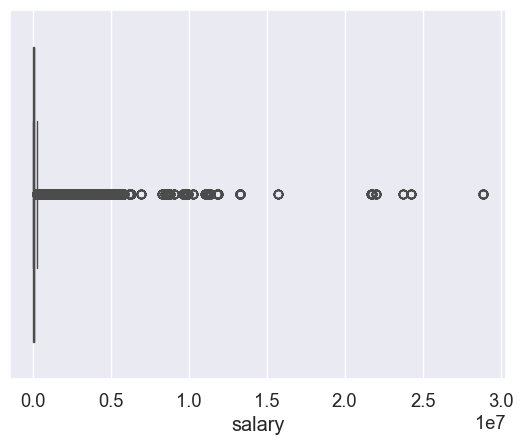

In [269]:
sns.boxplot(x=cs['salary'])

##### Outliers

No hay ningún outlier relevante.

In [270]:
cs[cs['salary']>25000000]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
1118605,1396113,2018-05,ES,28.0,V,25,N,28894395.51
1366031,1396113,2018-06,ES,28.0,V,25,N,28894395.51
1777762,1396113,2018-07,ES,28.0,V,25,N,28894395.51
1782564,1371668,2018-07,ES,28.0,H,45,N,28894395.51
1936341,1396113,2018-08,ES,28.0,V,25,N,28894395.51
2005009,1371668,2018-08,ES,28.0,H,45,N,28894395.51
2446137,1396113,2018-09,ES,28.0,V,25,N,28894395.51
2486788,1371668,2018-09,ES,28.0,H,45,N,28894395.51
2750378,1371668,2018-10,ES,28.0,H,45,N,28894395.51
2767586,1396113,2018-10,ES,28.0,V,25,N,28894395.51


In [273]:
cs[(cs['salary']<2000) & (cs['salary']>0)]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
205335,1215606,2018-01,ES,45.0,V,21,N,1202.73
250305,1215606,2018-02,ES,45.0,V,21,N,1202.73
487024,1215606,2018-03,ES,45.0,V,21,N,1202.73
731600,1215606,2018-04,ES,45.0,V,21,N,1202.73
1217489,1215606,2018-05,ES,45.0,V,21,N,1202.73
1470926,1215606,2018-06,ES,45.0,V,21,N,1202.73
1761350,1215606,2018-07,ES,45.0,V,21,N,1202.73
2119109,1215606,2018-08,ES,45.0,V,22,N,1202.73
2256385,1215606,2018-09,ES,45.0,V,22,N,1202.73
2550081,1215606,2018-10,ES,45.0,V,22,N,1202.73


#### region code

In [274]:
cs["region_code"] = cs["region_code"].astype(int)

region_code muestra el código INE de cada provincia, por tanto, se realiza un mapeo de la variable para mostrar el nombre de la provincia.

In [275]:
map_INE = {
    1: "ALAVA",
    2: "ALBACETE",
    3: "ALICANTE",
    4: "ALMERIA",
    5: "AVILA",
    6: "BADAJOZ",
    7: "ISLAS BALEARES",
    8: "BARCELONA",
    9: "BURGOS",
    10: "CACERES",
    11: "CADIZ",
    12: "CASTELLON",
    13: "CIUDAD REAL",
    14: "CORDOBA",
    15: "A CORUNA",
    16: "CUENCA",
    17: "GIRONA",
    18: "GRANADA",
    19: "GUADALAJARA",
    20: "GUIPUZCOA",
    21: "HUELVA",
    22: "HUESCA",
    23: "JAEN",
    24: "LEON",
    25: "LLEIDA",
    26: "LA RIOJA",
    27: "LUGO",
    28: "MADRID",
    29: "MALAGA",
    30: "MURCIA",
    31: "NAVARRA",
    32: "OURENSE",
    33: "ASTURIAS",
    34: "PALENCIA",
    35: "LAS PALMAS",
    36: "PONTEVEDRA",
    37: "SALAMANCA",
    38: "SANTA CRUZ DE TENERIFE",
    39: "CANTABRIA",
    40: "SEGOVIA",
    41: "SEVILLA",
    42: "SORIA",
    43: "TARRAGONA",
    44: "TERUEL",
    45: "TOLEDO",
    46: "VALENCIA",
    47: "VALLADOLID",
    48: "VIZCAYA",
    49: "ZAMORA",
    50: "ZARAGOZA",
    51: "CEUTA",
    52: "MELILLA"
}

In [276]:
cs["region"] = cs["region_code"].map(map_INE)

In [277]:
del(cs["region_code"])

#### gender

In [278]:
cs["gender"].unique()

array(['H', 'V'], dtype=object)

Se transforma la variable categórica gender en una booleana que indica si el cliente es masculino. 

In [279]:
cs.loc[(cs["gender"] == 'H'),'gender'] = '0'
cs.loc[(cs["gender"] == 'V'),'gender'] = '1'

cs["gender"] = cs["gender"].astype(int)

cs['gender'].unique()

array([0, 1])

In [280]:
cs = cs.rename(columns={"gender":"gender_male"})

#### deceased

In [281]:
cs["deceased"].value_counts(normalize=True)

deceased
N    0.99982
S    0.00018
Name: proportion, dtype: float64

Al ser un porcentaje pequeño de fallecidos y el objetivo es predecir que clientes son propensos a un productos se eliminan los clientes fallecidos del dataframe.

In [282]:
unique_deceased_customers = cs[cs['deceased'] == 1]['pk_cid'].unique()

cs.drop(cs[cs['pk_cid'].isin(unique_deceased_customers)].index, inplace=True)

Una vez eliminados los clientes fallecidos se elimina la variable.

In [283]:
del (cs['deceased'])

#### country id

In [284]:
cs['country_id'].unique()

array(['ES'], dtype=object)

Al tener un único valor se elimina la variable.

In [285]:
del(cs['country_id'])

#### Guardar pickle

In [286]:
pd.to_pickle(cs,"pickle/cs_clean_v1")

### Product description

In [4]:
pde = pd.read_csv('csv/product_description.csv', sep=",")

In [5]:
pde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 548.0+ bytes


In [6]:
pde.head(13)

,Unnamed: 0,pk_product_ID,product_desc,family_product
0,0,4657,em_acount,account
1,1,3819,debit_card,payment_card
2,2,1364,pension_plan,pension_plan
3,3,2234,payroll,account
4,4,2235,payroll_account,account
5,5,8871,emc_account,account
6,6,2312,credit_card,payment_card
7,7,2335,short_term_deposit,investment
8,8,2336,long_term_deposit,investment
9,9,2673,securities,investment


In [7]:
del(pde["Unnamed: 0"])

In [8]:
pde.isnull().sum()

pk_product_ID     0
product_desc      0
family_product    0
dtype: int64

In [9]:
pde['product_desc'].unique()

array(['em_acount', 'debit_card', 'pension_plan', 'payroll',
       'payroll_account', 'emc_account', 'credit_card',
       'short_term_deposit', 'long_term_deposit', 'securities', 'funds',
       'loans', 'mortgage'], dtype=object)

In [10]:
pde['family_product'].unique()

array(['account', 'payment_card', 'pension_plan', 'investment', 'loan'],
      dtype=object)

#### Guardar pickle

In [12]:
# pd.to_pickle(pde,"/content/drive/MyDrive/MASTER/TFM/TFM/pickle/fco/pde_clean_v1")
pd.to_pickle(pde,"pickle/pde_clean_v1")

### Sales

In [93]:
# s = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM_Finanzas/sales.csv', sep=",")
s = pd.read_csv('csv/sales.csv', sep=",")

In [94]:
s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB


In [95]:
s

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin
0,0,6666,33620,2018-05-01,2335,952.9
1,1,6667,35063,2018-06-01,2335,1625.2
2,2,6668,37299,2018-02-01,2335,1279.7
3,3,6669,39997,2018-02-01,2335,1511.9
4,4,6670,44012,2018-02-01,2335,1680.3
...,...,...,...,...,...,...
240768,240768,247434,1553456,2019-05-01,4657,56.7
240769,240769,247435,1553541,2019-05-01,4657,66.5
240770,240770,247436,1553559,2019-05-01,4657,73.0
240771,240771,247437,1553565,2019-05-01,4657,82.3


In [96]:
del(s['Unnamed: 0'])

In [97]:
s.isnull().sum()

pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

#### month_sale

In [98]:
s['month_sale'] = pd.to_datetime(s['month_sale'])

#### net_margin

<Axes: >

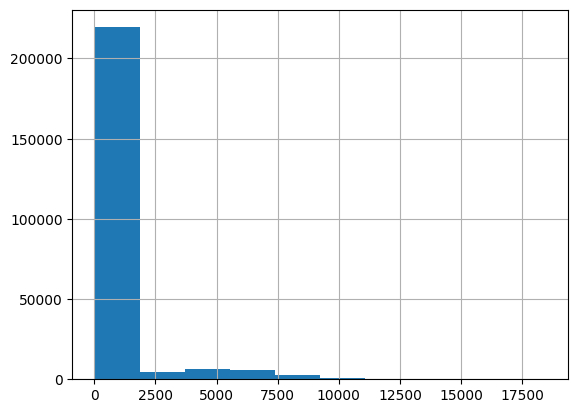

In [99]:
s['net_margin'].hist()

In [55]:
s[s['net_margin']>16000]

,pk_sale,cid,month_sale,product_ID,net_margin
36834,43500,1078554,2018-04-01,1364,16612.4
39199,45865,1158112,2018-02-01,1364,17076.8
40470,47136,1208380,2019-05-01,1364,17133.2
44180,50846,1312441,2019-05-01,1364,16657.0
44677,51343,1330238,2018-02-01,1364,18466.4
45626,52292,1359311,2018-10-01,1364,16219.3
46188,52854,1373494,2018-07-01,1364,16536.4
47358,54024,1385669,2019-03-01,1364,16572.1
47527,54193,1387129,2019-02-01,1364,16115.7
48092,54758,1392613,2018-07-01,1364,17615.6


In [56]:
s[s['net_margin']<=0]

,pk_sale,cid,month_sale,product_ID,net_margin


#### Guardar pickle

In [100]:
pd.to_pickle(s,"pickle/s_clean_v1")

### Union de los dataframes

In [2]:
cca_clean = pd.read_pickle('pickle/cca_clean_v1')
cp_clean = pd.read_pickle('pickle/cp_clean_v1')
cs_clean = pd.read_pickle('pickle/cs_clean_v1')
pde_clean = pd.read_pickle('pickle/pde_clean_v1')
s_clean = pd.read_pickle('pickle/s_clean_v1')

In [3]:
df_merge = pd.merge(cca_clean,cp_clean,on=["pk_cid","pk_partition"],how="inner")
df_clientes = pd.merge(df_merge,cs_clean,on=["pk_cid","pk_partition"],how="inner")
df_ventas = pd.merge(s_clean,pde_clean,left_on='product_ID',right_on="pk_product_ID",how="inner")

In [8]:
df_ventas.T

,0,1,2,3,4,5,6,7,8,9,...,240763,240764,240765,240766,240767,240768,240769,240770,240771,240772
pk_sale,6666,6667,6668,6669,6670,6671,6672,6673,6674,6675,...,247429,247430,247431,247432,247433,247434,247435,247436,247437,247438
cid,33620,35063,37299,39997,44012,66770,100296,101658,114080,124554,...,1553390,1553393,1553415,1553429,1553436,1553456,1553541,1553559,1553565,1553571
month_sale,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00,2018-02-01 00:00:00,2018-06-01 00:00:00,2018-04-01 00:00:00,2018-08-01 00:00:00,2018-03-01 00:00:00,2018-10-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
product_ID,2335,2335,2335,2335,2335,2335,2335,2335,2335,2335,...,4657,4657,4657,4657,4657,4657,4657,4657,4657,4657
net_margin,952.9,1625.2,1279.7,1511.9,1680.3,1772.0,1391.9,1466.7,1772.9,1534.5,...,66.5,68.4,82.5,75.9,54.2,56.7,66.5,73.0,82.3,84.4
pk_product_ID,2335,2335,2335,2335,2335,2335,2335,2335,2335,2335,...,4657,4657,4657,4657,4657,4657,4657,4657,4657,4657
product_desc,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,short_term_deposit,...,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount,em_acount
family_product,investment,investment,investment,investment,investment,investment,investment,investment,investment,investment,...,account,account,account,account,account,account,account,account,account,account


Eliminamos variables para liberar memoria.

In [19]:
del cca_clean, cp_clean, cs_clean, pde_clean, s_clean, df_merge

In [20]:
df_ventas_target = df_ventas[df_ventas['product_desc']== target_product]

In [21]:
df_ventas_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38840 entries, 84498 to 123337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pk_sale         38840 non-null  int64         
 1   cid             38840 non-null  int64         
 2   month_sale      38840 non-null  datetime64[ns]
 3   product_ID      38840 non-null  int64         
 4   net_margin      38840 non-null  float64       
 5   pk_product_ID   38840 non-null  int64         
 6   product_desc    38840 non-null  object        
 7   family_product  38840 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 2.7+ MB


In [22]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960574 entries, 0 to 5960573
Data columns (total 24 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        object        
 2   entry_date          datetime64[ns]
 3   entry_channel       object        
 4   active_customer     float64       
 5   segment             object        
 6   short_term_deposit  int64         
 7   loans               int64         
 8   mortgage            int64         
 9   funds               int64         
 10  securities          int64         
 11  long_term_deposit   int64         
 12  credit_card         int64         
 13  payroll             int32         
 14  pension_plan        int32         
 15  payroll_account     int64         
 16  emc_account         int64         
 17  debit_card          int64         
 18  em_account_p        int64         
 19  em_acount           int64         
 20  ge

In [23]:
df_clientes['pk_partition'] = pd.to_datetime(df_clientes['pk_partition'], format = "%Y-%m")

In [24]:
print(f'Clientes:{df_clientes.shape}')
df = pd.merge(df_clientes,df_ventas_target,left_on=["pk_cid","pk_partition"],right_on= ['cid','month_sale'], how="left")
print(f'df:{df.shape}')


Clientes:(5960574, 24)
df:(5960574, 32)


Eliminamos variables para liberar memoria.

In [25]:
del df_clientes, df_ventas

Transformamos product_desc en nuestra variable Target.

In [26]:
df['product_desc'].unique()

array([nan, 'debit_card'], dtype=object)

In [27]:
df['product_desc'] = df['product_desc'].fillna(0)
df['product_desc'] = np.where(df['product_desc'] == target_product, 1, df['product_desc'])
df['product_desc'] = df['product_desc'].astype(int)
df['product_desc'].unique()

array([0, 1])

In [28]:
df = df.rename(columns={"product_desc":target})

Se eliminan del dataset las columnas de ventas que no ofrecen información relevante para entrenar el modelo.

In [29]:
COLUMNS_TO_DROP = {
    'pk_sale',
    'cid',
    'month_sale',
    'product_ID',
    'net_margin',
    'pk_product_ID',
    'family_product'
}

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [30]:
df

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,...,payroll_account,emc_account,debit_card,em_account_p,em_acount,gender_male,age,salary,region,debit_card_sale
0,1375586,2018-01-01,2018-01-01,KHL,1.0,PARTICULARES,0,0,0,0,...,0,0,0,0,1,0,35,87218.10,MALAGA,0
1,1050611,2018-01-01,2015-08-01,KHE,0.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,1,23,35548.74,CIUDAD REAL,0
2,1050612,2018-01-01,2015-08-01,KHE,0.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,1,23,122179.11,CIUDAD REAL,0
3,1050613,2018-01-01,2015-08-01,KHD,0.0,UNIVERSITARIO,1,0,0,0,...,0,0,0,0,0,0,22,119775.54,ZARAGOZA,0
4,1050614,2018-01-01,2015-08-01,KHE,1.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,1,23,-1.00,ZARAGOZA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5960569,1166765,2019-05-01,2016-08-01,KHE,0.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,1,22,43912.17,ZARAGOZA,0
5960570,1166764,2019-05-01,2016-08-01,KHE,0.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,1,23,23334.99,LA RIOJA,0
5960571,1166763,2019-05-01,2016-08-01,KHE,1.0,PARTICULARES,0,0,0,0,...,0,0,0,0,1,0,47,-1.00,ZARAGOZA,0
5960572,1166789,2019-05-01,2016-08-01,KHE,0.0,UNIVERSITARIO,0,0,0,0,...,0,0,0,0,1,0,22,199592.82,ZARAGOZA,0


### Guardar pickle

In [31]:
pd.to_pickle(df,f"pickle/df_{target_product}_v1")

## Data understanding

In [4]:
df = pd.read_pickle(f"pickle/df_{target_product}_v1")

Se crea una lista vacía donde se introducirán las variables que no se consideran adecuadas para entrenar al modelo.

In [5]:
COLUMNS_TO_DROP = []

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960574 entries, 0 to 5960573
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pk_cid              int64         
 1   pk_partition        datetime64[ns]
 2   entry_date          datetime64[ns]
 3   entry_channel       object        
 4   active_customer     float64       
 5   segment             object        
 6   short_term_deposit  int64         
 7   loans               int64         
 8   mortgage            int64         
 9   funds               int64         
 10  securities          int64         
 11  long_term_deposit   int64         
 12  credit_card         int64         
 13  payroll             int32         
 14  pension_plan        int32         
 15  payroll_account     int64         
 16  emc_account         int64         
 17  debit_card          int64         
 18  em_account_p        int64         
 19  em_acount           int64         
 20  ge

In [35]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
pk_cid,5960574.0,NaN,NaN,NaN,1234968.141016,15891.0,1112557.0,1231126.0,1352358.0,1553689.0,162272.439918
pk_partition,5960574,NaN,NaN,NaN,2018-10-03 16:31:19.337934080,2018-01-01 00:00:00,2018-07-01 00:00:00,2018-11-01 00:00:00,2019-02-01 00:00:00,2019-05-01 00:00:00,NaN
entry_date,5960574,NaN,NaN,NaN,2017-01-26 22:33:14.495430144,2015-01-01 00:00:00,2016-01-01 00:00:00,2016-12-01 00:00:00,2017-11-01 00:00:00,2019-05-01 00:00:00,NaN
entry_channel,5960574,69,KHE,3113725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active_customer,5960574.0,NaN,NaN,NaN,0.40328,0.0,0.0,0.0,1.0,1.0,0.490556
segment,5960574,4,UNIVERSITARIO,3899820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
short_term_deposit,5960574.0,NaN,NaN,NaN,0.002582,0.0,0.0,0.0,0.0,1.0,0.050747
loans,5960574.0,NaN,NaN,NaN,0.000079,0.0,0.0,0.0,0.0,1.0,0.008861
mortgage,5960574.0,NaN,NaN,NaN,0.000054,0.0,0.0,0.0,0.0,1.0,0.007373
funds,5960574.0,NaN,NaN,NaN,0.003366,0.0,0.0,0.0,0.0,1.0,0.057922


### Análisis univariante

#### Target

In [36]:
df[target].value_counts(normalize=True) * 100

debit_card_sale
0    99.34867
1     0.65133
Name: proportion, dtype: float64

Teniendo en cuenta la desproporcion existente se tendrá que utilizar **data undersampling**.  

Undersampling (submuestreo) es una técnica utilizada en el preprocesamiento de datos para abordar el problema de clases desbalanceadas. 
- Reduce el sesgo del modelo
- Mejora el rendimiento
- Reduce el tiempo de entrenamiento
- Facilita la interpretación del modelo
- Minimiza el overfitting

#### Clasificacion de variables

In [6]:
def getList(df, notInList):
    lista_numericas = []
    lista_categoricas = []
    lista_booleanas = []

    for i in df:
        if (df[i].dtype.kind == 'f' or df[i].dtype.kind == 'i') and len(df[i].unique())!= 2 and (i not in notInList):
            lista_numericas.append(i)

        if (df[i].dtype.kind == 'f' or df[i].dtype.kind == 'i') and len(df[i].unique()) == 2 and (i not in notInList):
            lista_booleanas.append(i)

        if (df[i].dtype.kind == 'O') and (i not in notInList):
            lista_categoricas.append(i)

    return lista_numericas,lista_categoricas,lista_booleanas



In [7]:
notInList = ['pk_cid', 'pk_partition', 'entry_date', target]

numericas,categoricas,booleanas = getList(df, notInList)

#### pk_partition

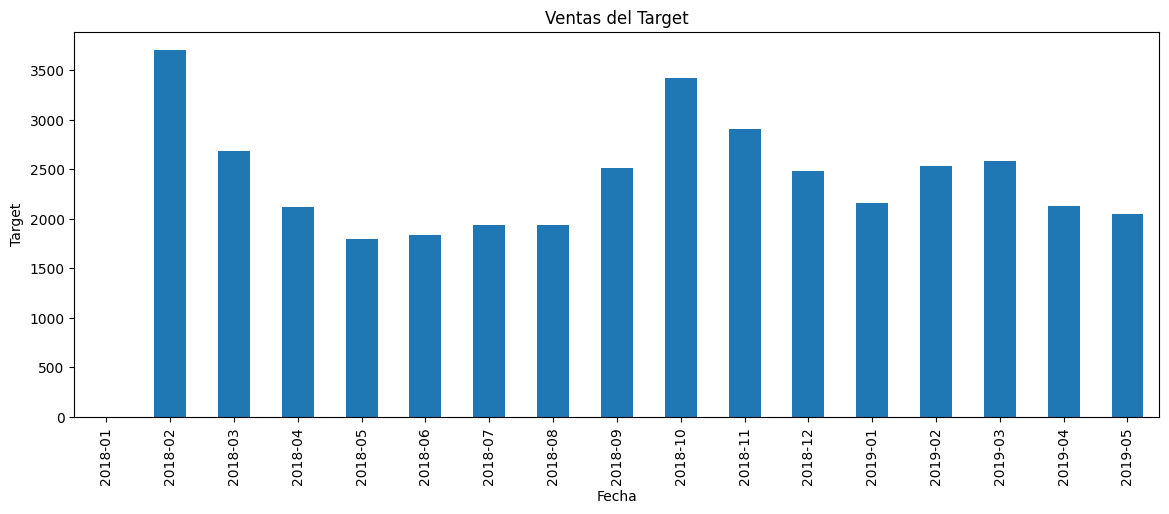

In [39]:
df.groupby(df['pk_partition'].dt.strftime('%Y-%m'))[target].sum().plot(kind='bar', figsize=(14, 5))
plt.title('Ventas del Target')
plt.xlabel('Fecha')
plt.ylabel('Target')
plt.show()

Al tener una muestra pequeña de año y medio no se pueden sacar conclusiones pero se puede apreciar cierta estacionalidad de la compra del producto.

#### entry_date

In [40]:
df['entry_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5960574 entries, 0 to 5960573
Series name: entry_date
Non-Null Count    Dtype         
--------------    -----         
5960574 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 45.5 MB


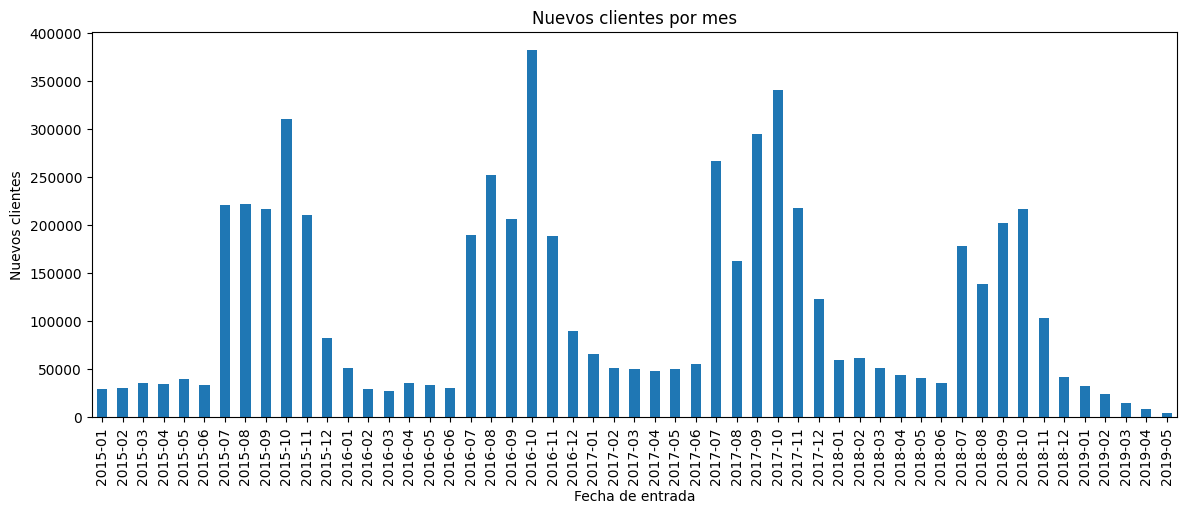

In [41]:
cantidad_clientes = df.groupby(df['entry_date'].dt.strftime('%Y-%m')).size()
cantidad_clientes.plot(kind='bar', figsize=(14, 5))
plt.title('Nuevos clientes por mes')
plt.xlabel('Fecha de entrada')
plt.ylabel('Nuevos clientes')
plt.show()

Se observa una tendencia de nuevos clientes en los meses de julio a noviembre.

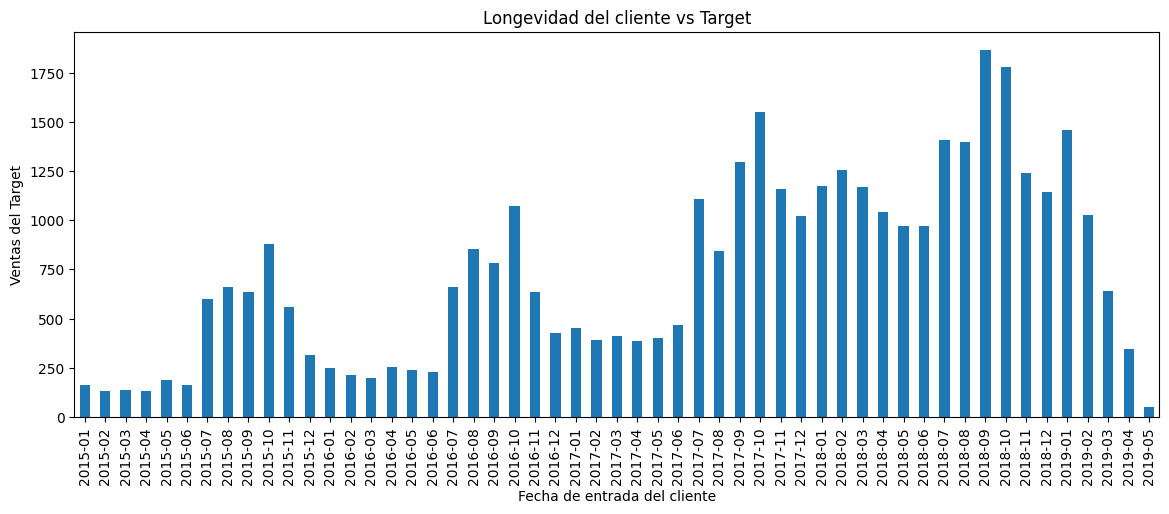

In [42]:
df.groupby(df['entry_date'].dt.strftime('%Y-%m'))[target].sum().plot(kind='bar', figsize=(14, 5))
plt.title('Longevidad del cliente vs Target')
plt.xlabel('Fecha de entrada del cliente')
plt.ylabel('Ventas del Target')
plt.show()

Se puede apreciar que los nuevos clientes son mas propensos a comprar el target.

#### Variables numéricas

In [43]:
print(f'Variables numéricas: {numericas}')

Variables numéricas: ['age', 'salary']


##### age

<Axes: xlabel='age', ylabel='Count'>

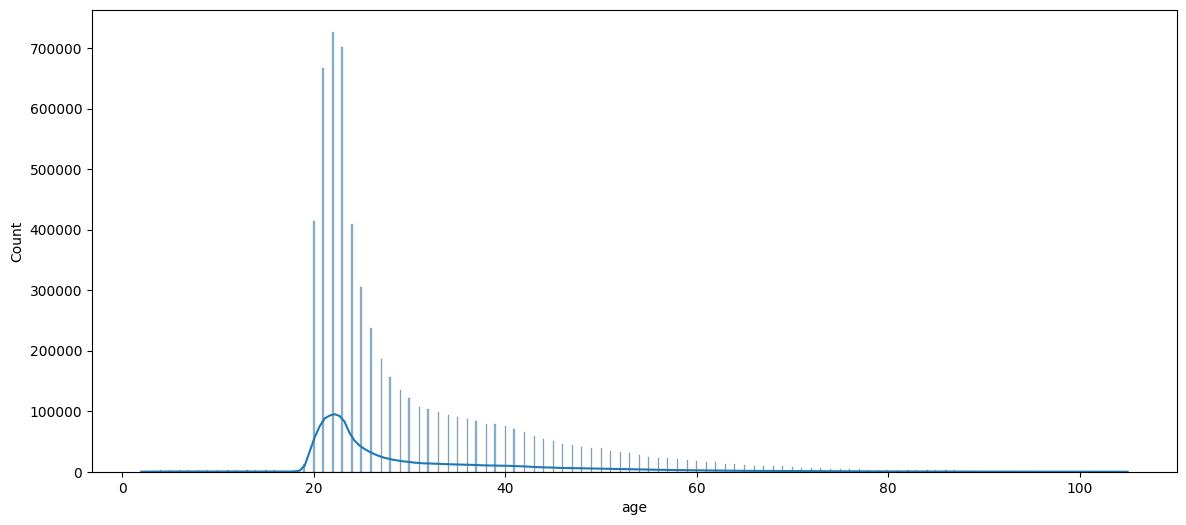

In [44]:
plt.figure(figsize=(14, 6))
sns.histplot(x="age",data=df, kde=True)

<Axes: xlabel='age'>

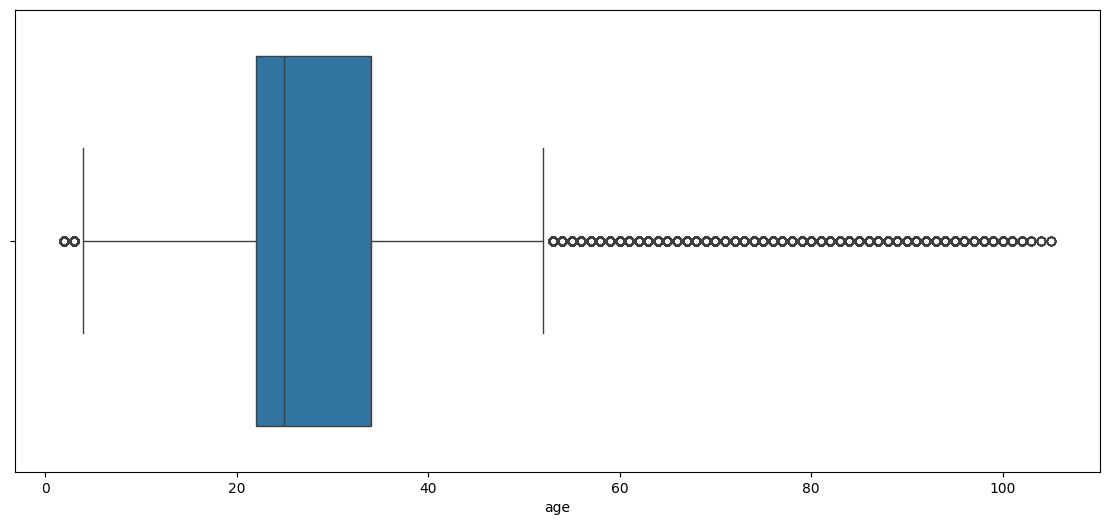

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="age", data=df)

La base de clientes se encuentra entre los 20 y 40 años.

<Axes: xlabel='debit_card_sale', ylabel='age'>

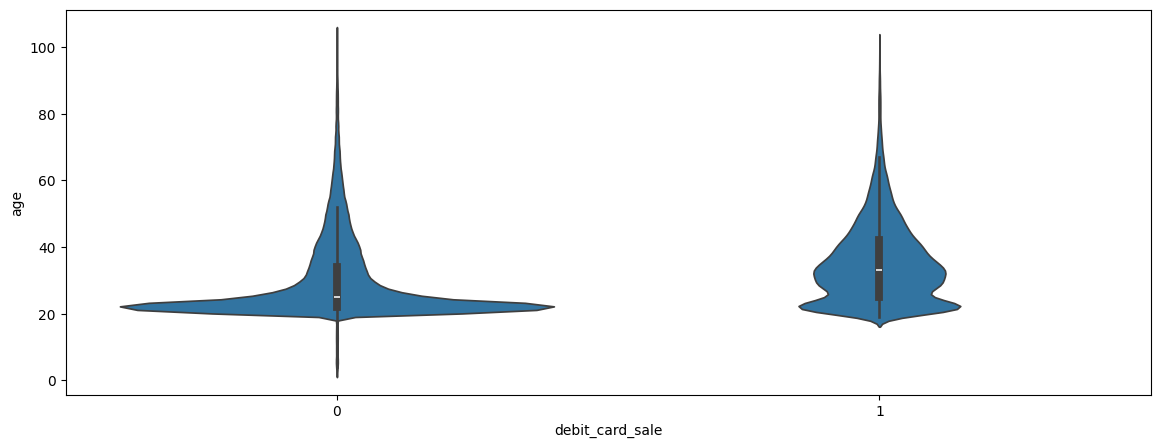

In [45]:
plt.figure(figsize=(14,5))
sns.violinplot(x=target, y="age", data=df)

Variable relevante para el target, se observa una disminución de las ventas en clientes jovenes y cierta tendencia de compra en algunos rangos de edad.

##### salary

<Axes: xlabel='salary'>

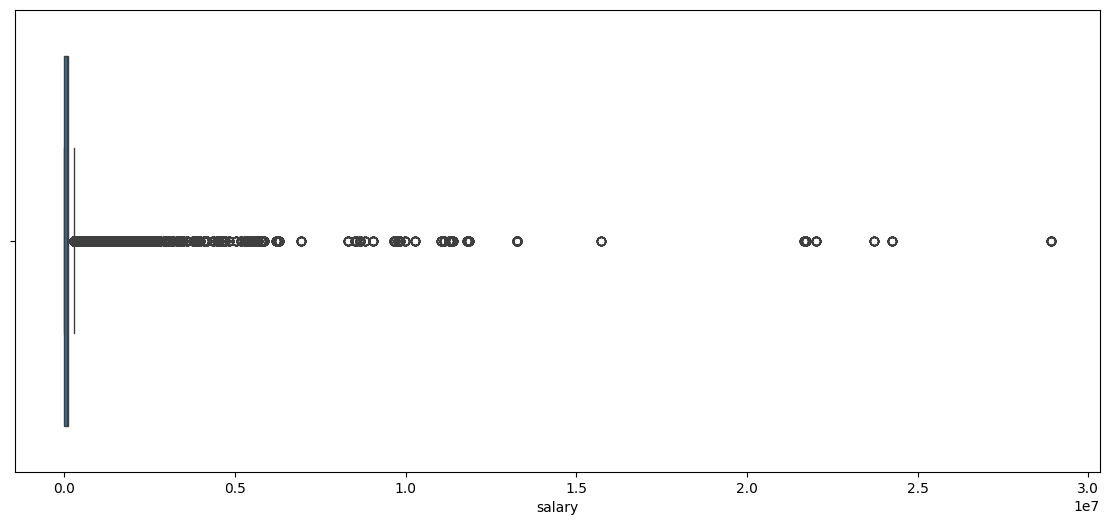

In [17]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="salary", data=df)

In [8]:
Q1 = df['salary'].quantile(0.25)
Q3 = df['salary'].quantile(0.75)
IQR = Q3 - Q1

df2 = df[(df['salary'] >= Q1 - 1.5 * IQR) & (df['salary'] <= Q3 + 1.5 * IQR)]

Se eliminan los outliers usando IQR (rango intercuartílico) para observar el violinplot.

<Axes: xlabel='debit_card_sale', ylabel='salary'>

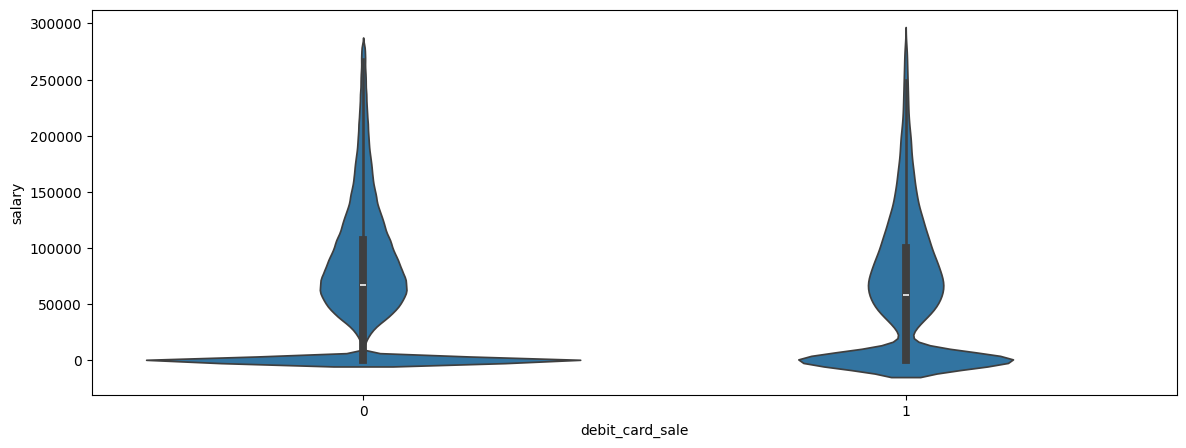

In [9]:
plt.figure(figsize=(14,5))
sns.violinplot(x=target, y="salary", data=df2)

#### Variables categóricas

In [10]:
print(f'Variables categóricas:{categoricas}')

Variables categóricas:['entry_channel', 'segment', 'region']


In [11]:
df_filter = df[df[target] == 1]

##### entry_channel

<function matplotlib.pyplot.show(close=None, block=None)>

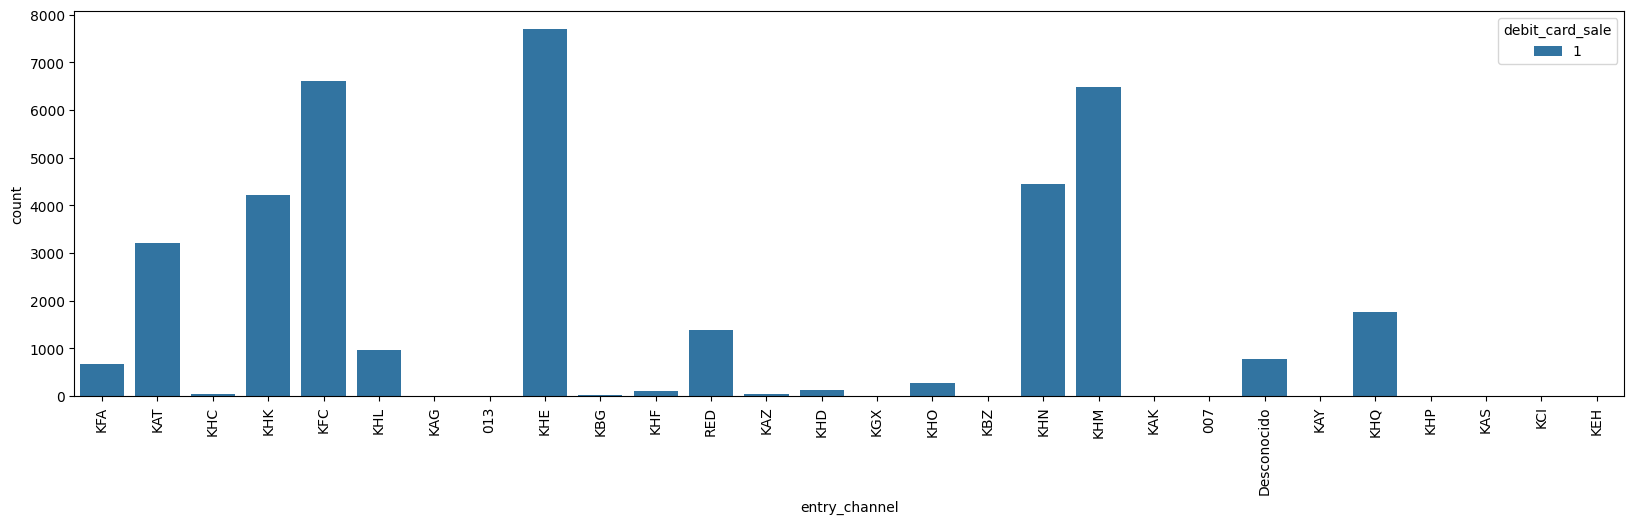

In [12]:
plt.figure(figsize=(20,5))
sns.countplot(x="entry_channel", hue=target, data=df_filter)
plt.xticks(rotation=90)
plt.show

##### segment

<Axes: xlabel='segment', ylabel='count'>

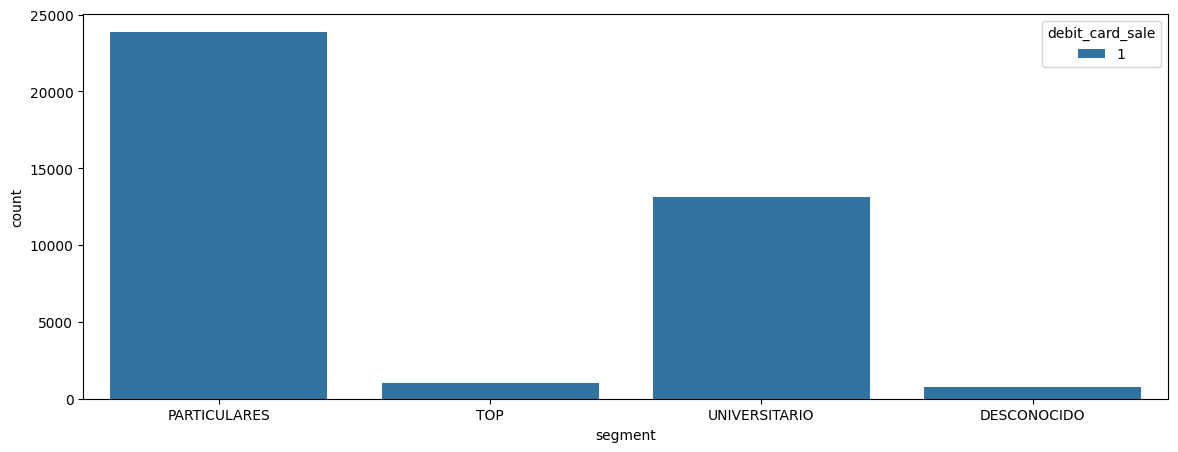

In [13]:
plt.figure(figsize=(14,5))
sns.countplot(x="segment", hue=target, data=df_filter)

Se aprecia cierta tendecia de compra en el segmento de particulares.

##### region

<function matplotlib.pyplot.show(close=None, block=None)>

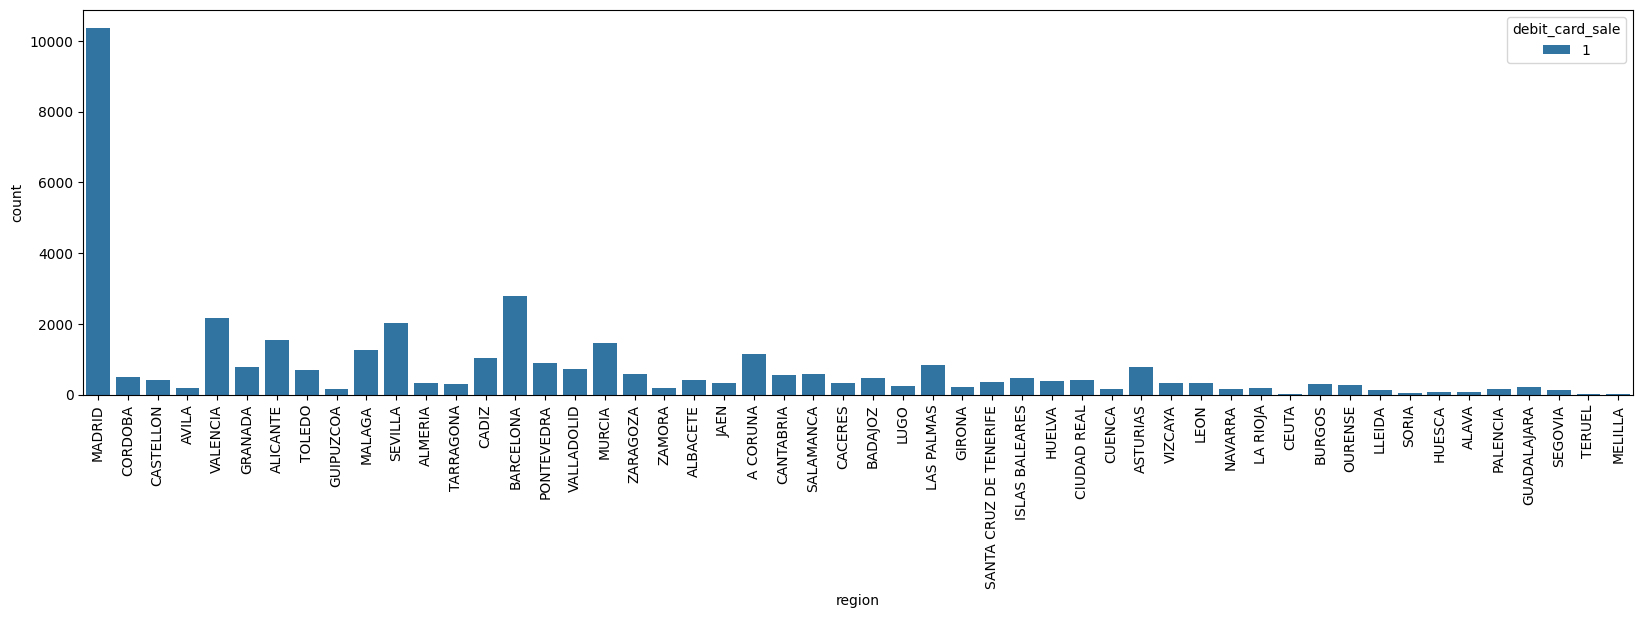

In [14]:
plt.figure(figsize=(20,5))
sns.countplot(x="region", hue=target, data=df_filter)
plt.xticks(rotation=90)
plt.show

#### Variables booleanas

In [15]:
print(f'Variables booleanas:{booleanas}')

Variables booleanas:['active_customer', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount', 'gender_male']


##### active_customer

<Axes: xlabel='active_customer', ylabel='count'>

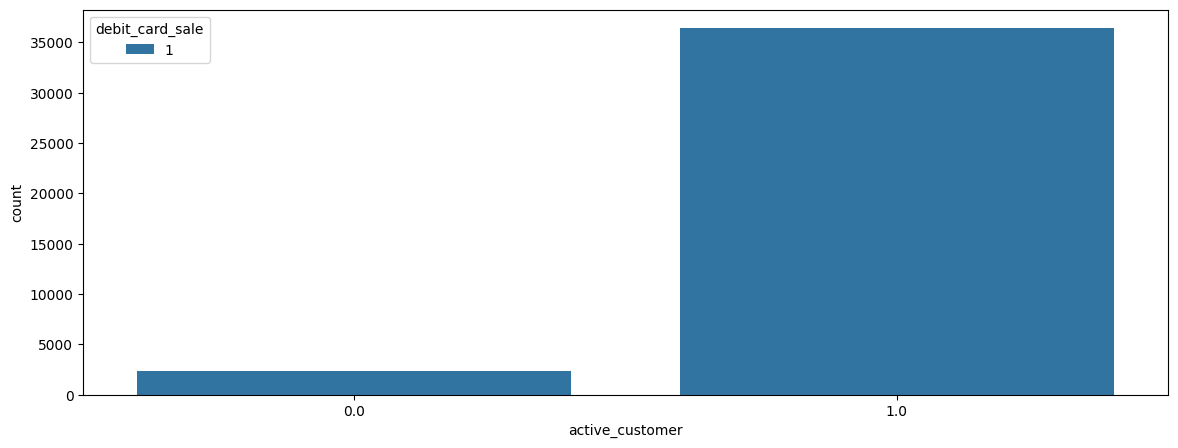

In [16]:
plt.figure(figsize=(14,5))
sns.countplot(x="active_customer", hue=target, data=df_filter)

Variable relevante para el modelo ya que un usuario inactivo es significativo de que no compra el target.

##### short_term_deposit

In [17]:
df['short_term_deposit'].value_counts()

short_term_deposit
0    5945184
1      15390
Name: count, dtype: int64

<Axes: xlabel='short_term_deposit', ylabel='count'>

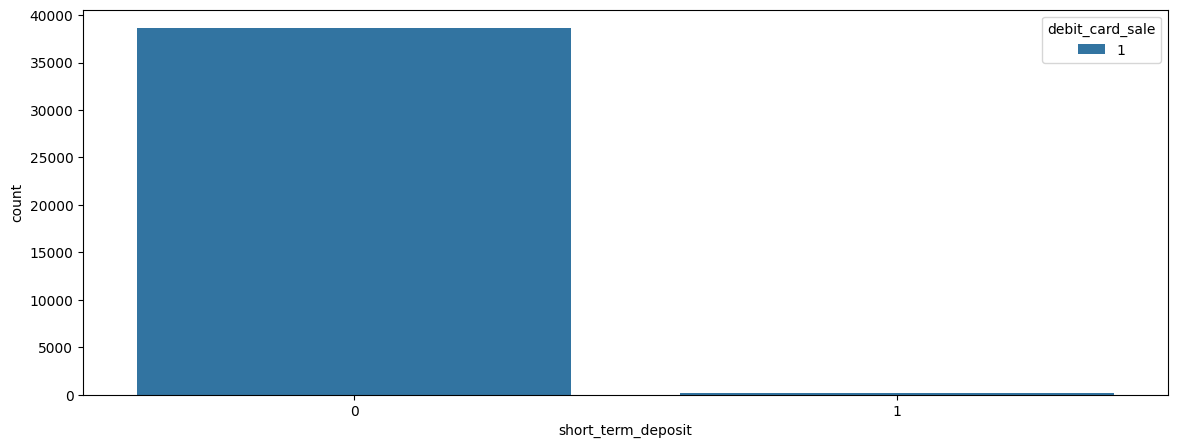

In [18]:
plt.figure(figsize=(14,5))
sns.countplot(x="short_term_deposit", hue=target, data=df_filter)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [19]:
COLUMNS_TO_DROP.append('short_term_deposit')

##### loans

In [20]:
df['loans'].value_counts()

loans
0    5960106
1        468
Name: count, dtype: int64

<Axes: xlabel='loans', ylabel='count'>

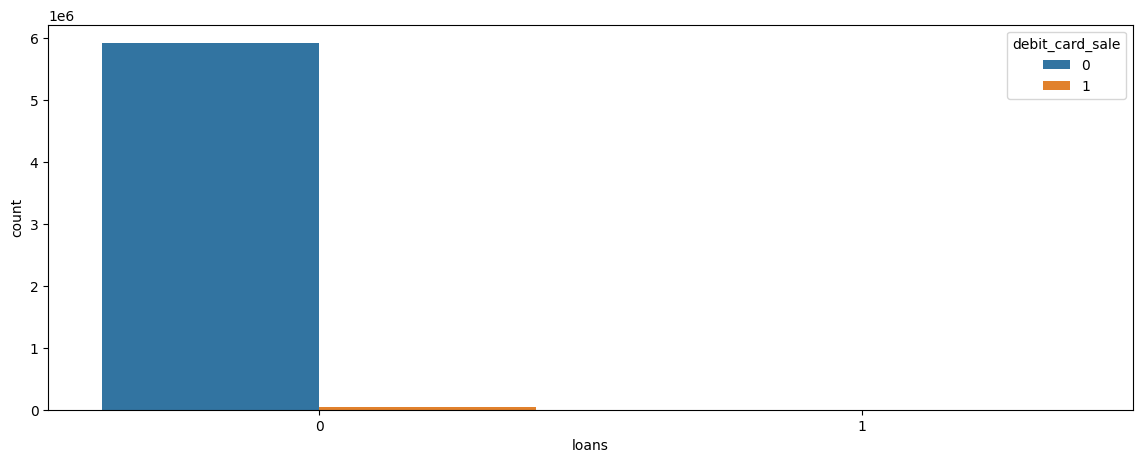

In [21]:
plt.figure(figsize=(14,5))
sns.countplot(x="loans", hue=target, data=df)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [22]:
COLUMNS_TO_DROP.append('loans')

##### mortgage

In [23]:
df['mortgage'].value_counts()

mortgage
0    5960250
1        324
Name: count, dtype: int64

<Axes: xlabel='mortgage', ylabel='count'>

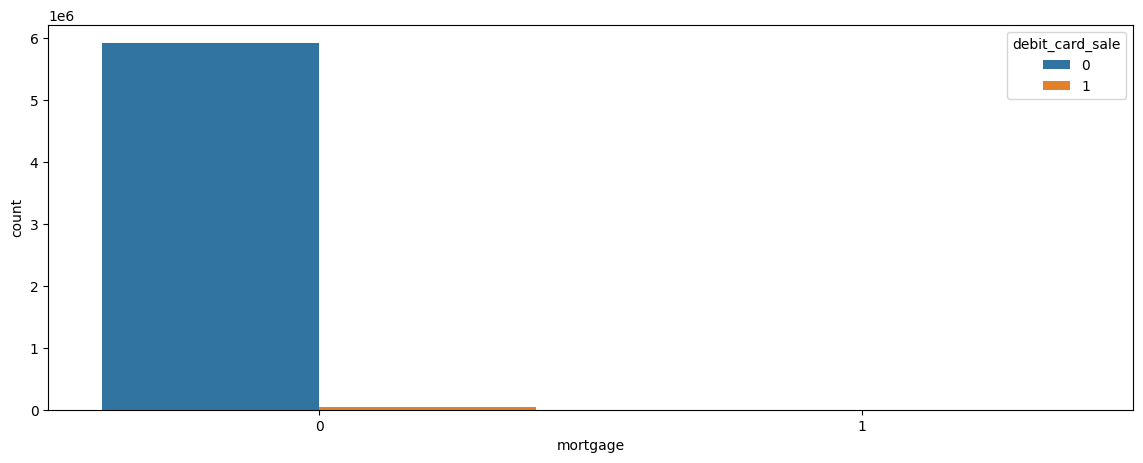

In [24]:
plt.figure(figsize=(14,5))
sns.countplot(x="mortgage", hue=target, data=df)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [25]:
COLUMNS_TO_DROP.append('mortgage')

##### funds

In [26]:
df['funds'].value_counts()

funds
0    5940509
1      20065
Name: count, dtype: int64

<Axes: xlabel='funds', ylabel='count'>

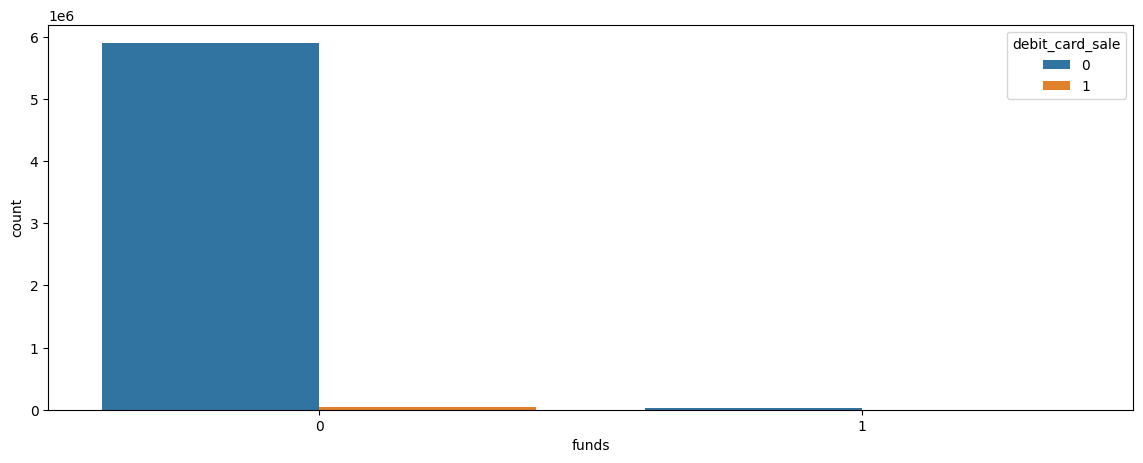

In [27]:
plt.figure(figsize=(14,5))
sns.countplot(x="funds", hue=target, data=df)

<Axes: xlabel='funds', ylabel='count'>

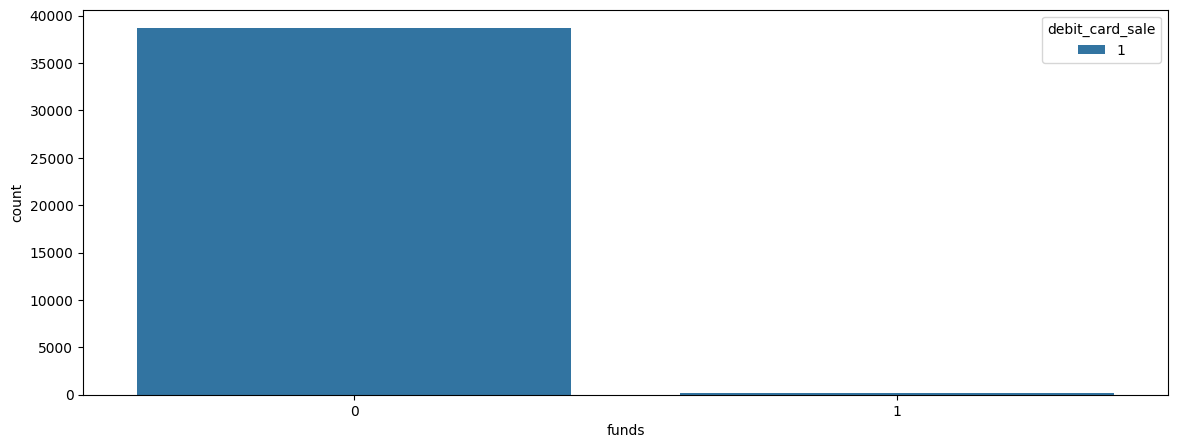

In [28]:
plt.figure(figsize=(14,5))
sns.countplot(x="funds", hue=target, data=df_filter)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [29]:
COLUMNS_TO_DROP.append('funds')

##### securities

In [30]:
df['securities'].value_counts()

securities
0    5938535
1      22039
Name: count, dtype: int64

<Axes: xlabel='securities', ylabel='count'>

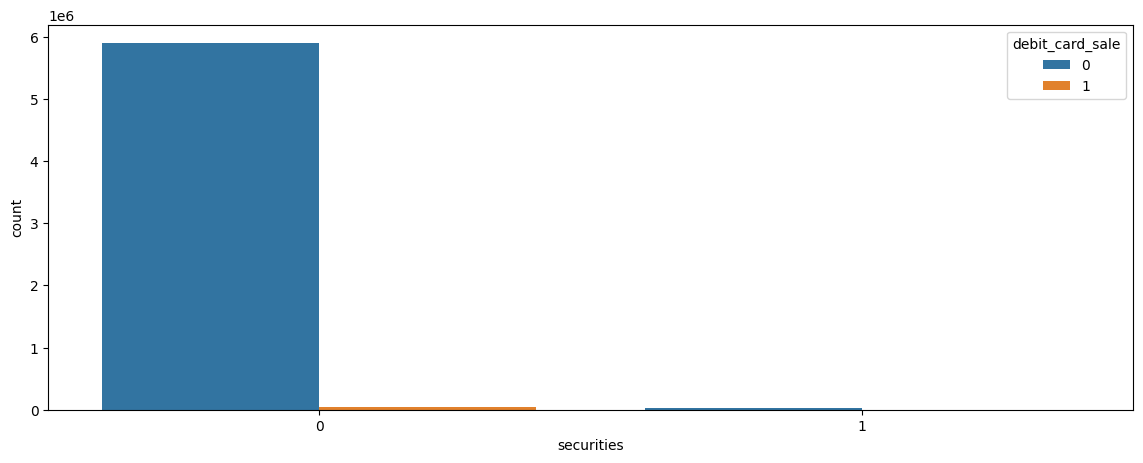

In [31]:
plt.figure(figsize=(14,5))
sns.countplot(x="securities", hue=target, data=df)

<Axes: xlabel='securities', ylabel='count'>

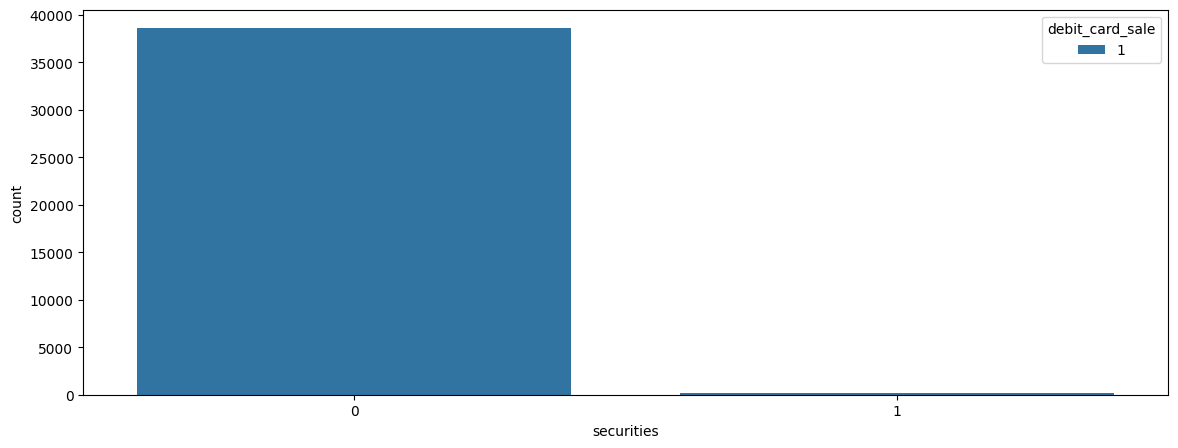

In [32]:
plt.figure(figsize=(14,5))
sns.countplot(x="securities", hue=target, data=df_filter)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [33]:
COLUMNS_TO_DROP.append('securities')

##### long_term_deposit

In [34]:
df['long_term_deposit'].value_counts()

long_term_deposit
0    5860119
1     100455
Name: count, dtype: int64

<Axes: xlabel='long_term_deposit', ylabel='count'>

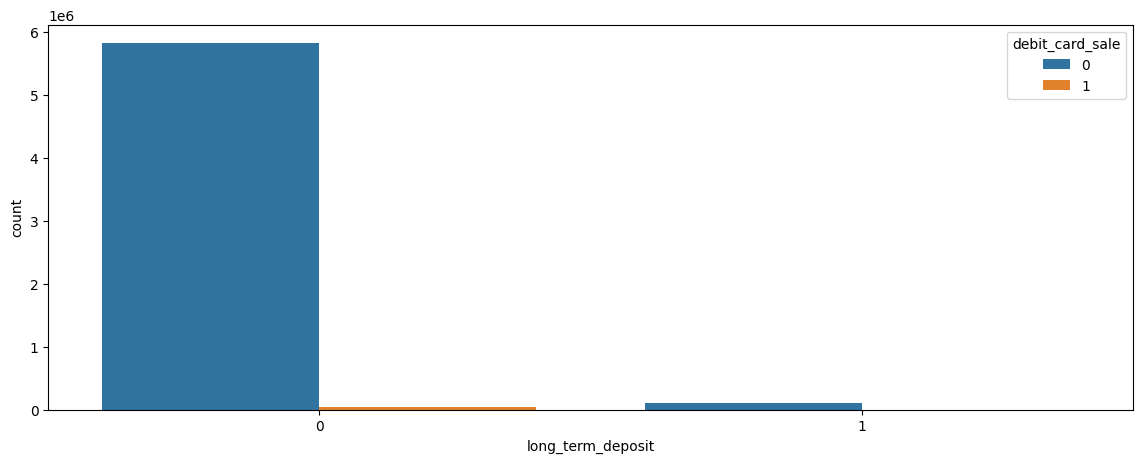

In [35]:
plt.figure(figsize=(14,5))
sns.countplot(x="long_term_deposit", hue=target, data=df)

<Axes: xlabel='long_term_deposit', ylabel='count'>

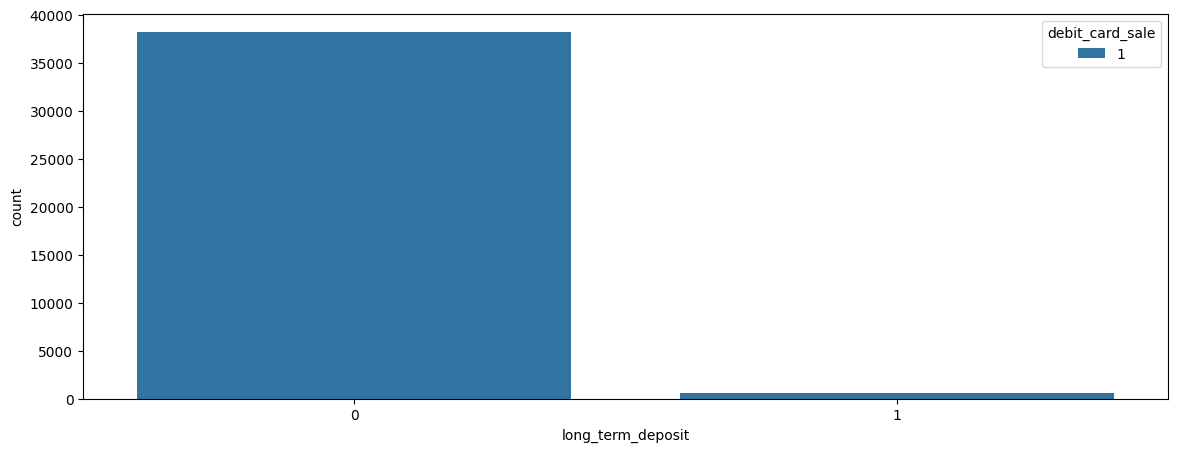

In [36]:
plt.figure(figsize=(14,5))
sns.countplot(x="long_term_deposit", hue=target, data=df_filter)

##### credit_card

In [37]:
df['credit_card'].value_counts()

credit_card
0    5889839
1      70735
Name: count, dtype: int64

<Axes: xlabel='credit_card', ylabel='count'>

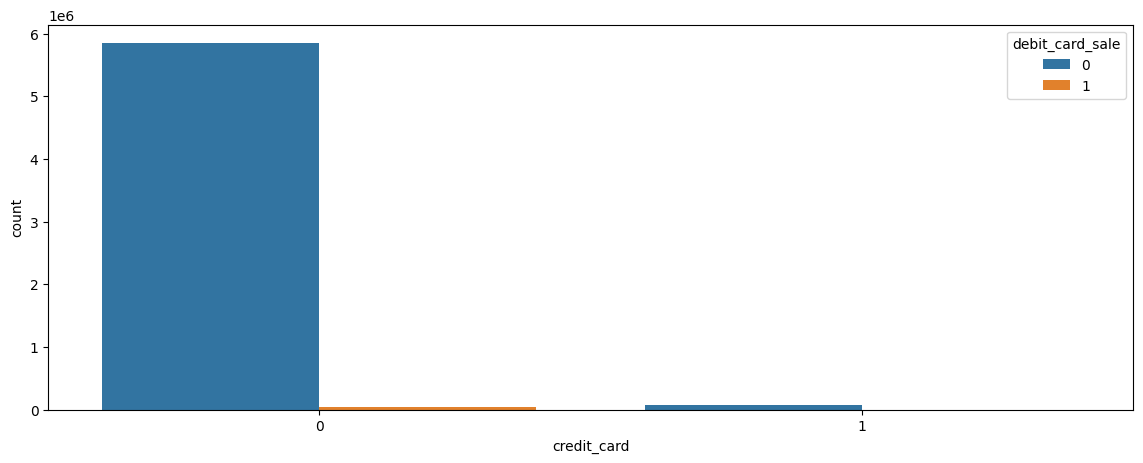

In [38]:
plt.figure(figsize=(14,5))
sns.countplot(x="credit_card", hue=target, data=df)

<Axes: xlabel='credit_card', ylabel='count'>

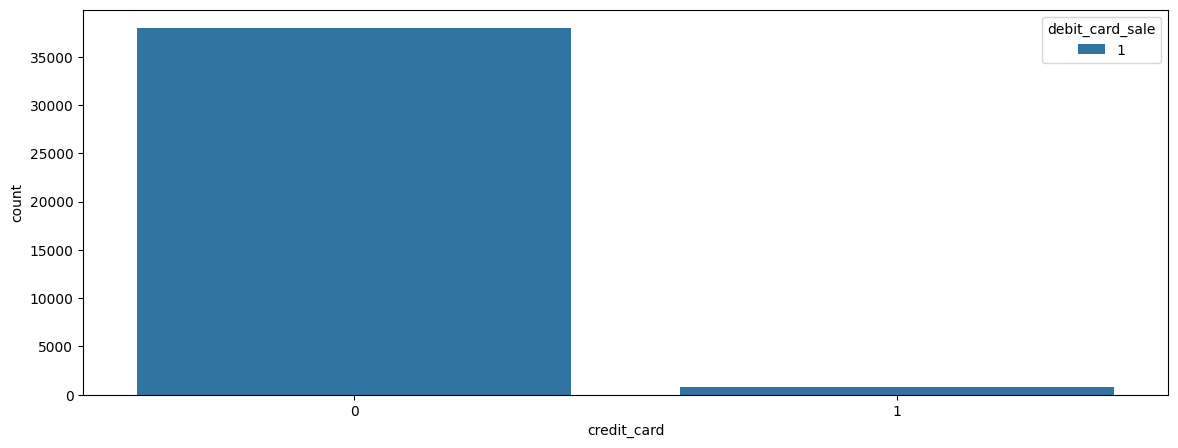

In [39]:
plt.figure(figsize=(14,5))
sns.countplot(x="credit_card", hue=target, data=df_filter)

##### payroll

In [40]:
df['payroll'].value_counts()

payroll
0    5754812
1     205762
Name: count, dtype: int64

<Axes: xlabel='payroll', ylabel='count'>

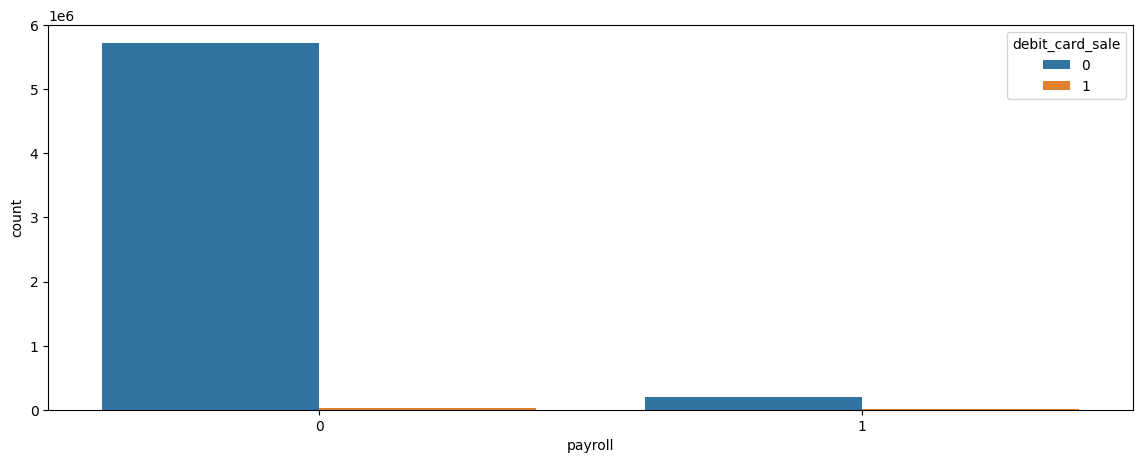

In [41]:
plt.figure(figsize=(14,5))
sns.countplot(x="payroll", hue=target, data=df)

<Axes: xlabel='credit_card', ylabel='count'>

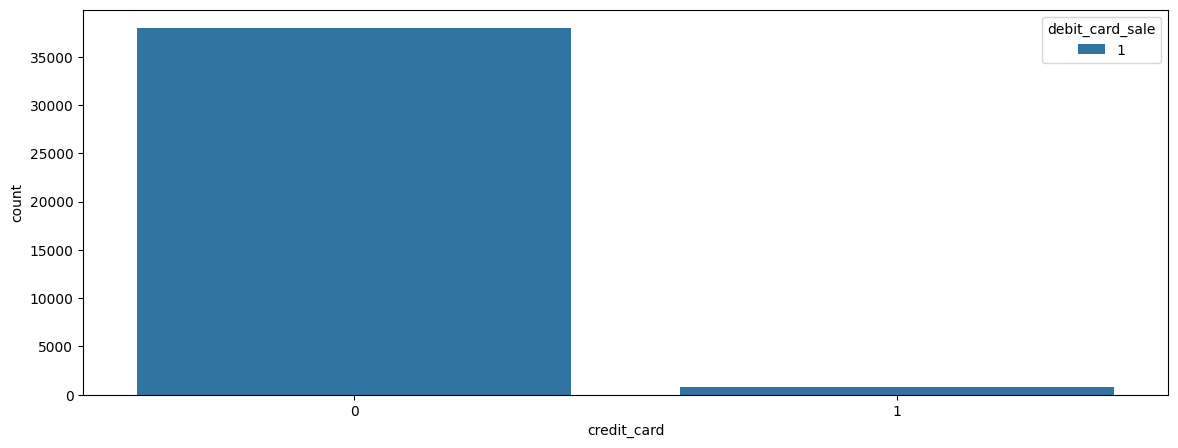

In [42]:
plt.figure(figsize=(14,5))
sns.countplot(x="credit_card", hue=target, data=df_filter)

##### payroll_account

In [46]:
df['payroll_account'].value_counts()

payroll_account
0    5631188
1     329386
Name: count, dtype: int64

<Axes: xlabel='payroll_account', ylabel='count'>

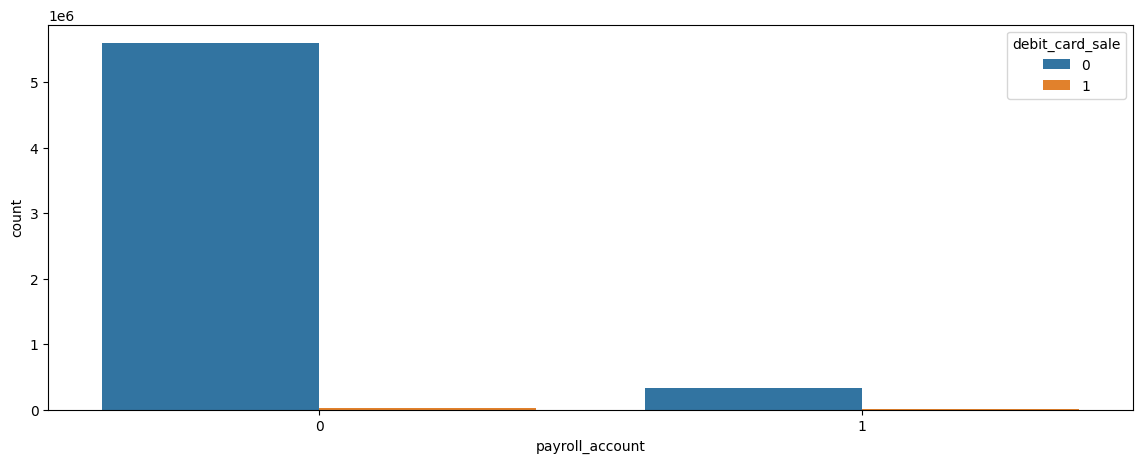

In [47]:
plt.figure(figsize=(14,5))
sns.countplot(x="payroll_account", hue=target, data=df)

<Axes: xlabel='payroll_account', ylabel='count'>

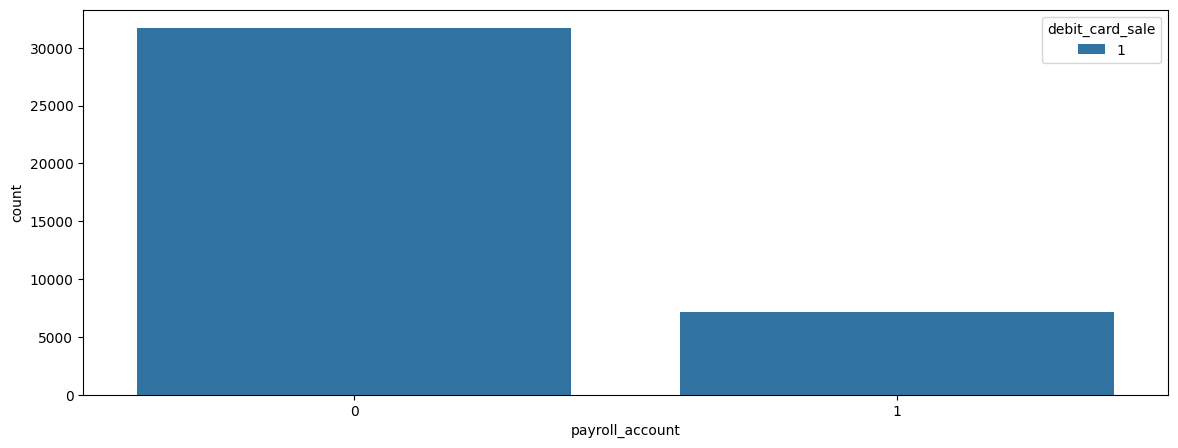

In [48]:
plt.figure(figsize=(14,5))
sns.countplot(x="payroll_account", hue=target, data=df_filter)

Variable relevante para el modelo que muestra cierta tendencia de los clientes a obtener ambos productos.

##### emc_account

In [49]:
df['emc_account'].value_counts()

emc_account
0    5634039
1     326535
Name: count, dtype: int64

<Axes: xlabel='emc_account', ylabel='count'>

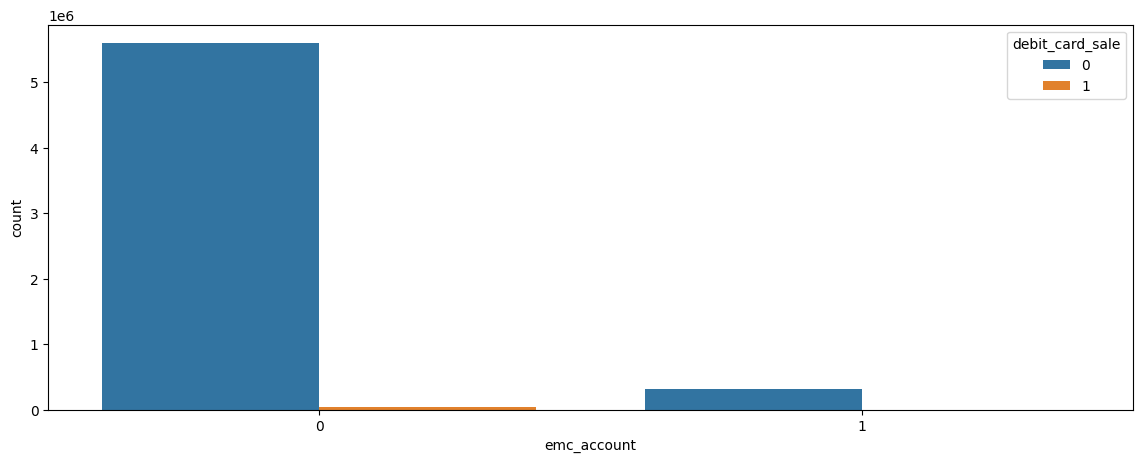

In [50]:
plt.figure(figsize=(14,5))
sns.countplot(x="emc_account", hue=target, data=df)

<Axes: xlabel='emc_account', ylabel='count'>

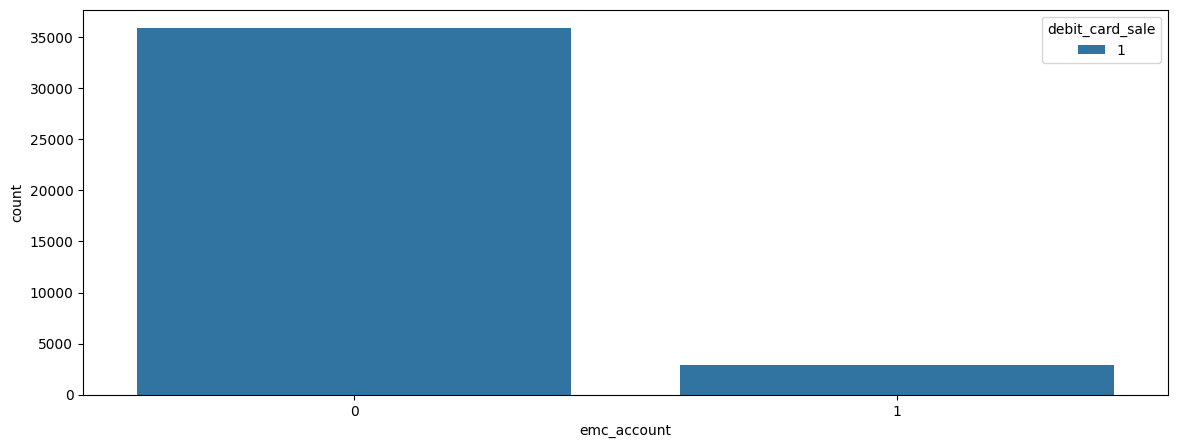

In [51]:
plt.figure(figsize=(14,5))
sns.countplot(x="emc_account", hue=target, data=df_filter)

##### em_account_p

In [52]:
df['em_account_p'].value_counts()

em_account_p
0    5960540
1         34
Name: count, dtype: int64

<Axes: xlabel='em_account_p', ylabel='count'>

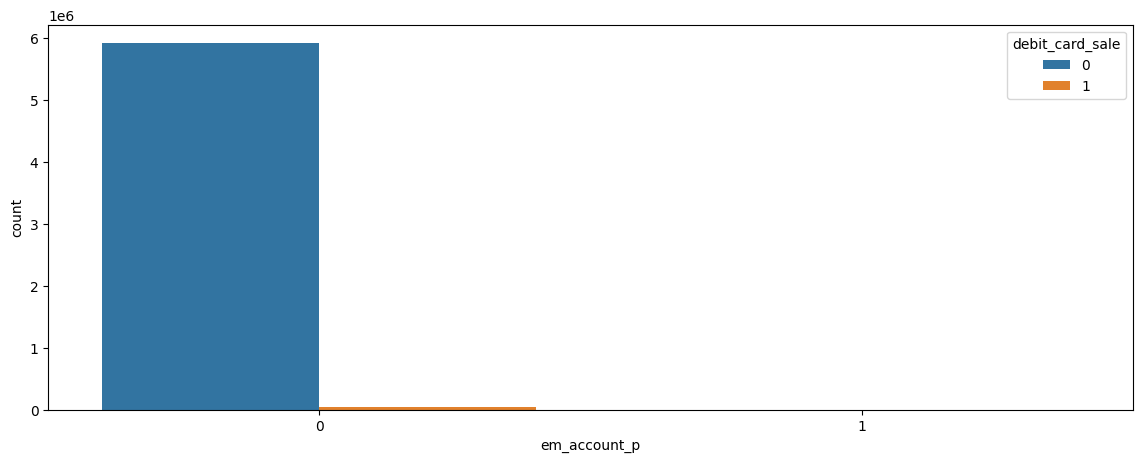

In [53]:
plt.figure(figsize=(14,5))
sns.countplot(x="em_account_p", hue=target, data=df)

Al tener pocos casos positivos es una variable que provoca que el modelo memorize.

In [54]:
COLUMNS_TO_DROP.append('em_account_p')

##### em_acount

In [55]:
df['em_acount'].value_counts()

em_acount
1    4379962
0    1580612
Name: count, dtype: int64

<Axes: xlabel='em_acount', ylabel='count'>

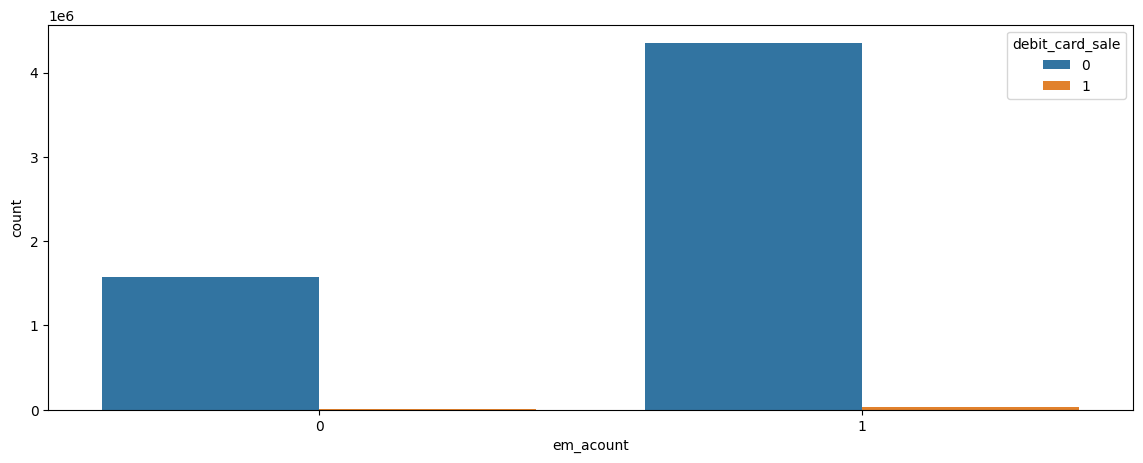

In [56]:
plt.figure(figsize=(14,5))
sns.countplot(x="em_acount", hue=target, data=df)

<Axes: xlabel='em_acount', ylabel='count'>

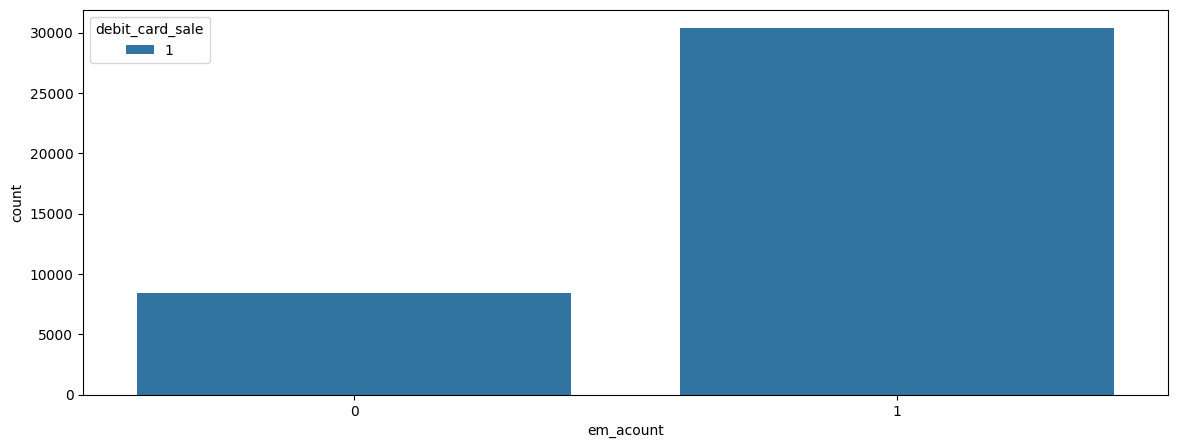

In [57]:
plt.figure(figsize=(14,5))
sns.countplot(x="em_acount", hue=target, data=df_filter)

Variable relevante para el modelo que muestra gran tendencia de los clientes a obtener ambos productos.

##### pension_plan

<Axes: xlabel='pension_plan', ylabel='count'>

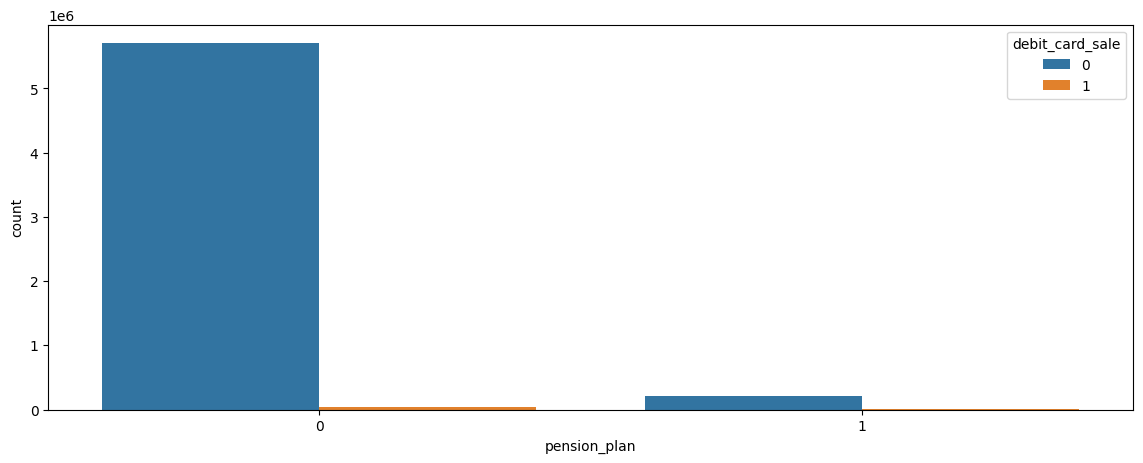

In [58]:
plt.figure(figsize=(14,5))
sns.countplot(x="pension_plan", hue=target, data=df)

<Axes: xlabel='pension_plan', ylabel='count'>

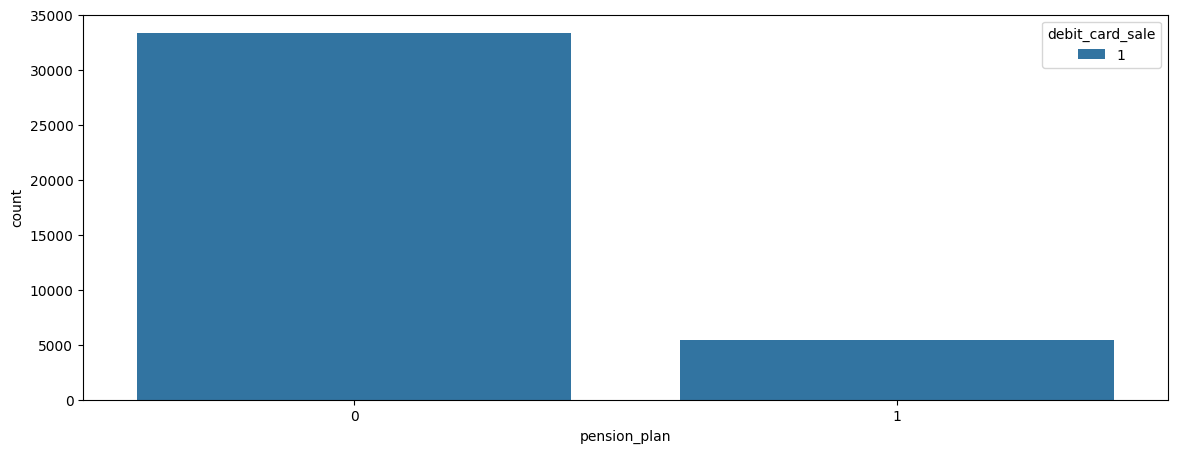

In [59]:
plt.figure(figsize=(14,5))
sns.countplot(x="pension_plan", hue=target, data=df_filter)

Variable relevante que muestra cierta tendencia a obtener ambos productos.

##### gender_male

<Axes: xlabel='gender_male', ylabel='count'>

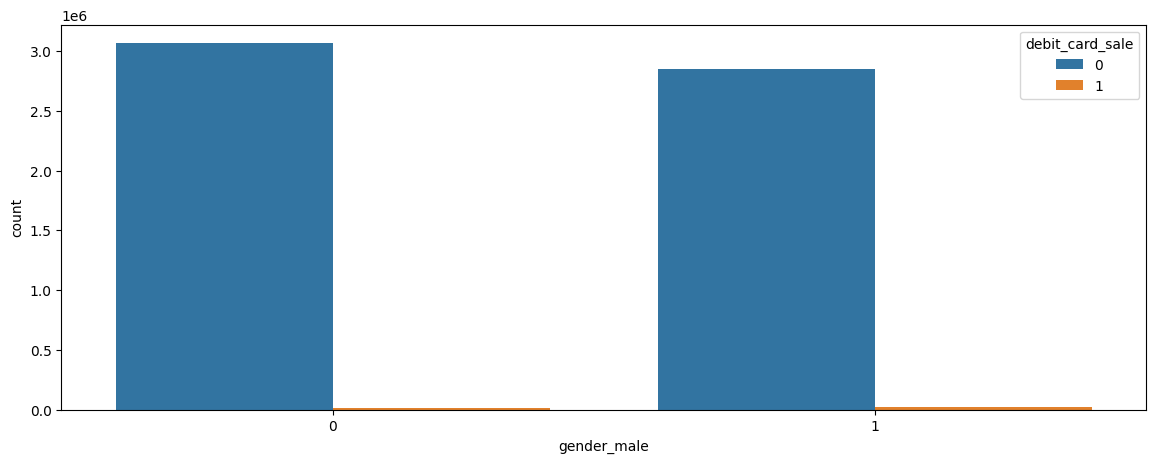

In [60]:
plt.figure(figsize=(14,5))
sns.countplot(x="gender_male", hue=target, data=df)

<Axes: xlabel='gender_male', ylabel='count'>

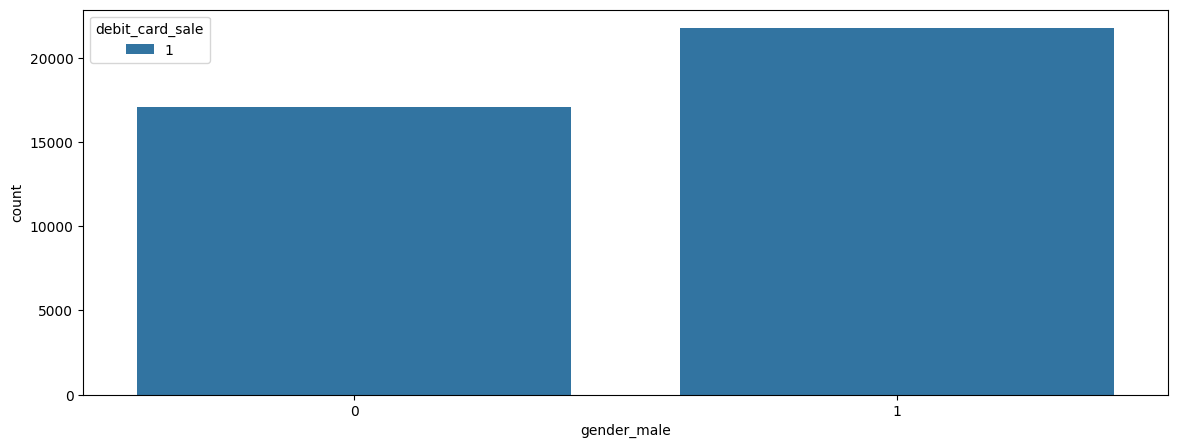

In [61]:
plt.figure(figsize=(14,5))
sns.countplot(x="gender_male", hue=target, data=df_filter)

### Eliminacion de variables

In [62]:
COLUMNS_TO_DROP

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'em_account_p']

In [63]:
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

### Guardar pickle

In [64]:
pd.to_pickle(df,f"pickle/df_{target_product}_v2")

## Data preparation

In [65]:
df = pd.read_pickle(f"pickle/df_{target_product}_v2")

### Variable entry_date

In [66]:
df['entry_date_diff'] = (df['pk_partition'].dt.year - df['entry_date'].dt.year) * 12 + (df['pk_partition'].dt.month - df['entry_date'].dt.month)

In [67]:
df['entry_date_month'] = df['entry_date'].dt.month
df['entry_date_year'] = df['entry_date'].dt.year

# Estas variables representan de manera cíclica el mes en una escala continua
df['entry_date_month_sin'] = np.sin(2 * np.pi * df['entry_date_month'] / 12)
df['entry_date_month_cos'] = np.cos(2 * np.pi * df['entry_date_month'] / 12)

df['entry_date_quarter'] = df['entry_date'].dt.quarter
del(df['entry_date'])

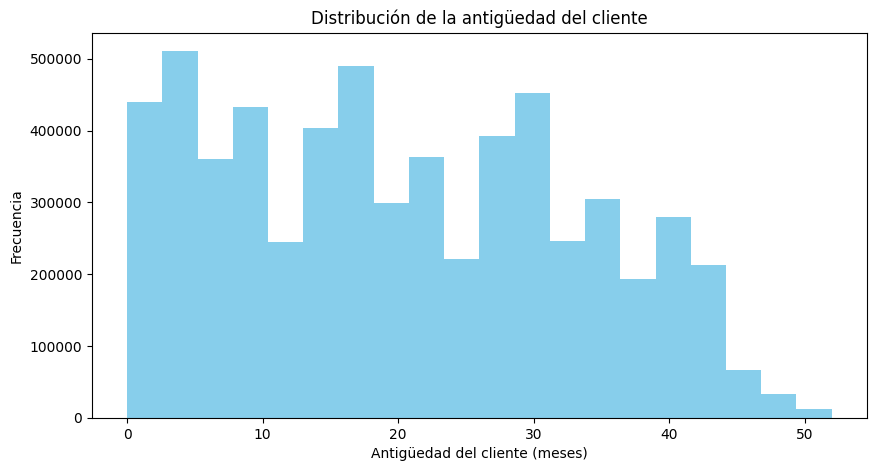

In [74]:
df['entry_date_diff'].plot(kind='hist', bins=20, figsize=(10, 5), color='skyblue')
plt.title('Distribución de la antigüedad del cliente')
plt.xlabel('Antigüedad del cliente (meses)')
plt.ylabel('Frecuencia')
plt.show()

### entry_channel

In [56]:
pd.set_option('display.max_rows', None)

In [57]:
df['entry_channel'].value_counts(normalize=True)*100

entry_channel
KHE            52.253248
KFC            14.922480
KHQ             9.905995
KAT             6.956336
KHK             3.861176
KHM             2.961860
Desconocido     2.231976
KHN             1.818803
KFA             1.320762
KHD             1.272044
RED             1.016521
KHL             0.699089
KHF             0.346666
KHO             0.138250
KAZ             0.094567
KHC             0.087955
KBG             0.027690
KEH             0.012217
KHP             0.011596
007             0.010287
013             0.006662
KAG             0.005622
KAS             0.005119
KBZ             0.003323
KAA             0.003239
KAR             0.002635
KAY             0.002501
KAF             0.002064
KAB             0.001594
KFD             0.001527
KCC             0.001494
KAW             0.001091
KAQ             0.000873
KDH             0.000856
KAE             0.000806
KCH             0.000806
KCB             0.000789
KAD             0.000755
KAM             0.000722
KAH        

In [59]:
pd.reset_option('display.max_columns')

In [68]:
vc = df['entry_channel'].value_counts(normalize=True)
replace_values = vc[vc < 0.05].index
df['entry_channel'] = df['entry_channel'].replace(replace_values, 'Other')

df['entry_channel'].value_counts(normalize=True)

entry_channel
KHE      0.522387
Other    0.159638
KFC      0.149308
KHQ      0.099031
KAT      0.069637
Name: proportion, dtype: float64

### Features

#### Acumulativo de productos

Cantidad de productos que ha comprado de forma acumulativa.

In [69]:
def cumsumToList (df: pd.DataFrame, list: list) -> pd.DataFrame:

    for i in list:
        df[f'{i}_cumsum'] = df.groupby('pk_cid')[i].cumsum()
        
    return df

In [70]:
productList = [
    'active_customer',
    'long_term_deposit',
    'credit_card',
    'payroll',
    'pension_plan',
    'payroll_account',
    'emc_account',
    'em_acount',
    # 'debit_card'
 ]

In [71]:
df = cumsumToList(df, productList)

#### Shift -1

Para poder entrenar el modelo de forma adecuada se realiza un shift -1 sobre el target.  
De esta forma, se le da al modelo la información correspondiente del mes anterior al que realiza la compra.  
El modelo estudia la situacion del target un mes antes de la compra, lo que permite obtener una lista de clientes propensos a comprar el producto el mes siguiente.  

Si se quisiera realizar una campaña con 3 meses de antelación, se realizaría un shift -3 sobre el target.

In [72]:
df[target] = df.groupby('pk_cid')[target].transform(
            lambda x: x.shift(-1).fillna(0)
        )

#### Lag

Se obtiene un historico de los 3 meses anteriores de las variables más relevantes para el target.

In [73]:
def getLags(df: pd.DataFrame, list: list, lags: int)-> pd.DataFrame:

    for var in list:
        for lag in range(lags):
            df[f"{var}_lag{lag + 1}"] = df.groupby('pk_cid')[var].transform(
                lambda x: x.shift(lag + 1).fillna(0)
            )

    return df

In [74]:
df = getLags(df,['active_customer', 'payroll_account', 'em_acount', 'pension_plan'], 3)

Se comprueba el resultado:

In [75]:
df3 = df[['pk_partition', 'pk_cid', target, target_product, 'active_customer' , 'active_customer_cumsum', 'active_customer_lag1', 'active_customer_lag2', 'active_customer_lag3']]

In [76]:
df3[df3['pk_cid'] == 1166753]

,pk_partition,pk_cid,debit_card_sale,debit_card,active_customer,active_customer_cumsum,active_customer_lag1,active_customer_lag2,active_customer_lag3
167735,2018-01-01,1166753,0.0,0,1.0,1.0,0.0,0.0,0.0
313974,2018-02-01,1166753,0.0,0,1.0,2.0,1.0,0.0,0.0
531462,2018-03-01,1166753,0.0,0,1.0,3.0,1.0,1.0,0.0
775395,2018-04-01,1166753,0.0,0,1.0,4.0,1.0,1.0,1.0
1173682,2018-05-01,1166753,0.0,0,1.0,5.0,1.0,1.0,1.0
1425786,2018-06-01,1166753,0.0,0,1.0,6.0,1.0,1.0,1.0
1536256,2018-07-01,1166753,1.0,0,1.0,7.0,1.0,1.0,1.0
2160453,2018-08-01,1166753,0.0,1,1.0,8.0,1.0,1.0,1.0
2391261,2018-09-01,1166753,0.0,1,1.0,9.0,1.0,1.0,1.0
2646159,2018-10-01,1166753,0.0,0,1.0,10.0,1.0,1.0,1.0


#### Comunidades autónomas

Para reducir los valores de la variable catégorica region se agrupan las provincias por comunidad autónoma.

In [77]:
comunidades_autonomas = {
    "ALAVA": "PAIS VASCO",
    "ALBACETE": "CASTILLA LA MANCHA",
    "ALICANTE": "COMUNIDAD VALENCIANA",
    "ALMERIA": "ANDALUCIA",
    "AVILA": "CASTILLA Y LEON",
    "BADAJOZ": "EXTREMADURA",
    "ISLAS BALEARES": "ISLAS BALEARES",
    "BARCELONA": "CATALUÑA",
    "BURGOS": "CASTILLA Y LEON",
    "CACERES": "EXTREMADURA",
    "CADIZ": "ANDALUCIA",
    "CASTELLON": "COMUNIDAD VALENCIANA",
    "CIUDAD REAL": "CASTILLA LA MANCHA",
    "CORDOBA": "ANDALUCIA",
    "A CORUNA": "GALICIA",
    "CUENCA": "CASTILLA LA MANCHA",
    "GIRONA": "CATALUÑA",
    "GRANADA": "ANDALUCIA",
    "GUADALAJARA": "CASTILLA LA MANCHA",
    "GUIPUZCOA": "PAIS VASCO",
    "HUELVA": "ANDALUCIA",
    "HUESCA": "ARAGON",
    "JAEN": "ANDALUCIA",
    "LEON": "CASTILLA Y LEON",
    "LLEIDA": "CATALUÑA",
    "LA RIOJA": "LA RIOJA",
    "LUGO": "GALICIA",
    "MADRID": "COMUNIDAD DE MADRID",
    "MALAGA": "ANDALUCIA",
    "MURCIA": "REGION DE MURCIA",
    "NAVARRA": "NAVARRA",
    "OURENSE": "GALICIA",
    "ASTURIAS": "ASTURIAS",
    "PALENCIA": "CASTILLA Y LEON",
    "LAS PALMAS": "CANARIAS",
    "PONTEVEDRA": "GALICIA",
    "SALAMANCA": "CASTILLA Y LEON",
    "SANTA CRUZ DE TENERIFE": "CANARIAS",
    "CANTABRIA": "CANTABRIA",
    "SEGOVIA": "CASTILLA Y LEON",
    "SEVILLA": "ANDALUCIA",
    "SORIA": "CASTILLA Y LEON",
    "TARRAGONA": "CATALUÑA",
    "TERUEL": "ARAGON",
    "TOLEDO": "CASTILLA LA MANCHA",
    "VALENCIA": "COMUNIDAD VALENCIANA",
    "VALLADOLID": "CASTILLA Y LEON",
    "VIZCAYA": "PAIS VASCO",
    "ZAMORA": "CASTILLA Y LEON",
    "ZARAGOZA": "ARAGON",
    "CEUTA": "CEUTA",
    "MELILLA": "MELILLA"
}

In [78]:
df['region_ca'] = df['region'].map(comunidades_autonomas)

In [79]:
df['region_ca'].value_counts()

region_ca
COMUNIDAD DE MADRID     1185719
ANDALUCIA                953106
CATALUÑA                 749772
COMUNIDAD VALENCIANA     598202
GALICIA                  538162
CASTILLA Y LEON          402621
CASTILLA LA MANCHA       307344
REGION DE MURCIA         296855
EXTREMADURA              205870
ARAGON                   166710
CANARIAS                 150982
ASTURIAS                 134561
CANTABRIA                 69588
PAIS VASCO                67087
ISLAS BALEARES            62436
LA RIOJA                  34789
NAVARRA                   31241
CEUTA                      2896
MELILLA                    2633
Name: count, dtype: int64

In [80]:
df_filter = df[df[target] == 1]

<function matplotlib.pyplot.show(close=None, block=None)>

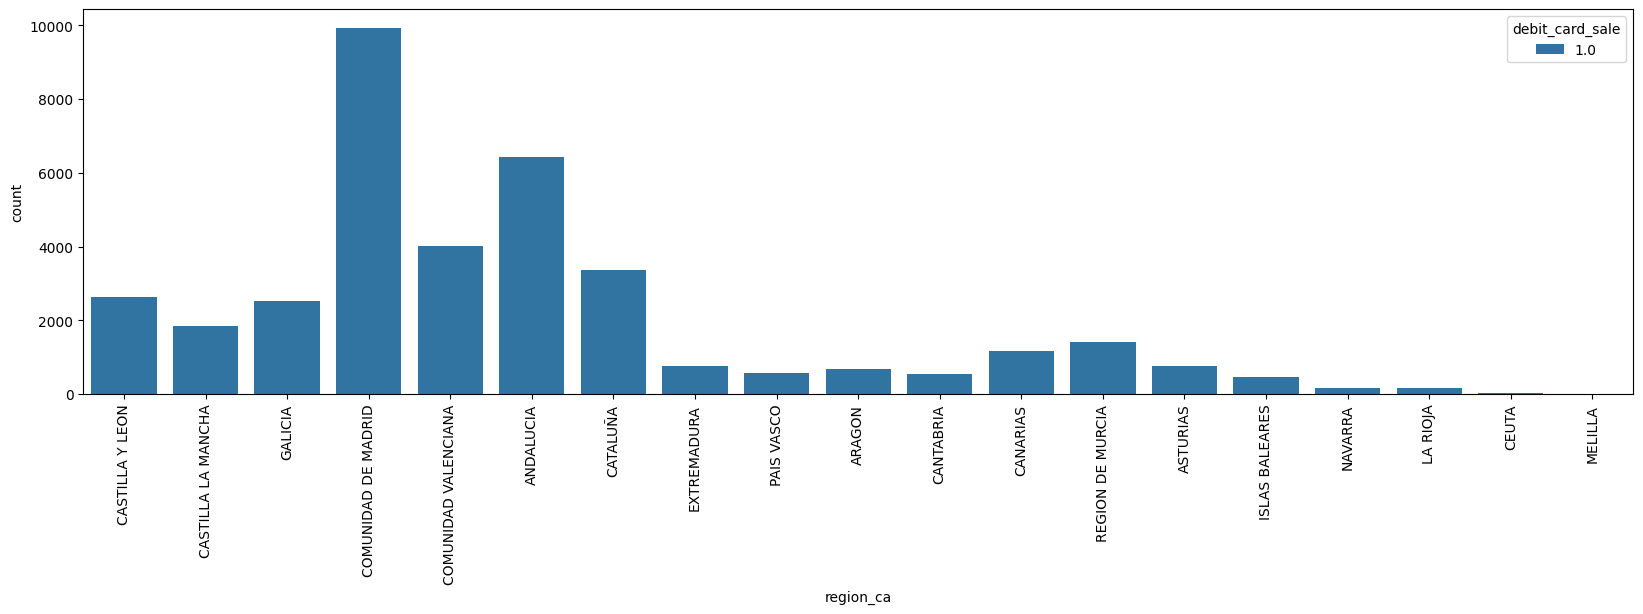

In [81]:
plt.figure(figsize=(20,5))
sns.countplot(x="region_ca", hue=target, data=df_filter)
plt.xticks(rotation=90)
plt.show

Se aprecian cierta tendencia de compra en algunas comunidades autónomas pero hay que tener en cuenta que también tienen más clientes como es el caso de Madrid.

In [82]:
del(df['region'])

### Data transformation

#### One hot encoding

In [83]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,5960564,5960565,5960566,5960567,5960568,5960569,5960570,5960571,5960572,5960573
pk_cid,1375586,1050611,1050612,1050613,1050614,1050615,1050616,1050617,1050619,1050620,...,1166770,1166769,1166768,1166767,1166766,1166765,1166764,1166763,1166789,1550586
pk_partition,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,...,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00,2019-05-01 00:00:00
entry_channel,Other,KHE,KHE,Other,KHE,KHE,KHE,KHE,KHE,KHE,...,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,Other
active_customer,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
segment,PARTICULARES,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,...,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,UNIVERSITARIO,PARTICULARES,UNIVERSITARIO,DESCONOCIDO
long_term_deposit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
credit_card,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
payroll,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pension_plan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
payroll_account,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
df = pd.get_dummies(data=df, columns=['entry_channel', 'segment', 'region_ca', 'entry_date_quarter'], dtype=int) 

##### Guardar pickle

In [85]:
pd.to_pickle(df,f"pickle/df_{target_product}_v3")

### Correlacion

In [86]:
X = df.drop(columns=[target,'pk_partition', 'pk_cid'])

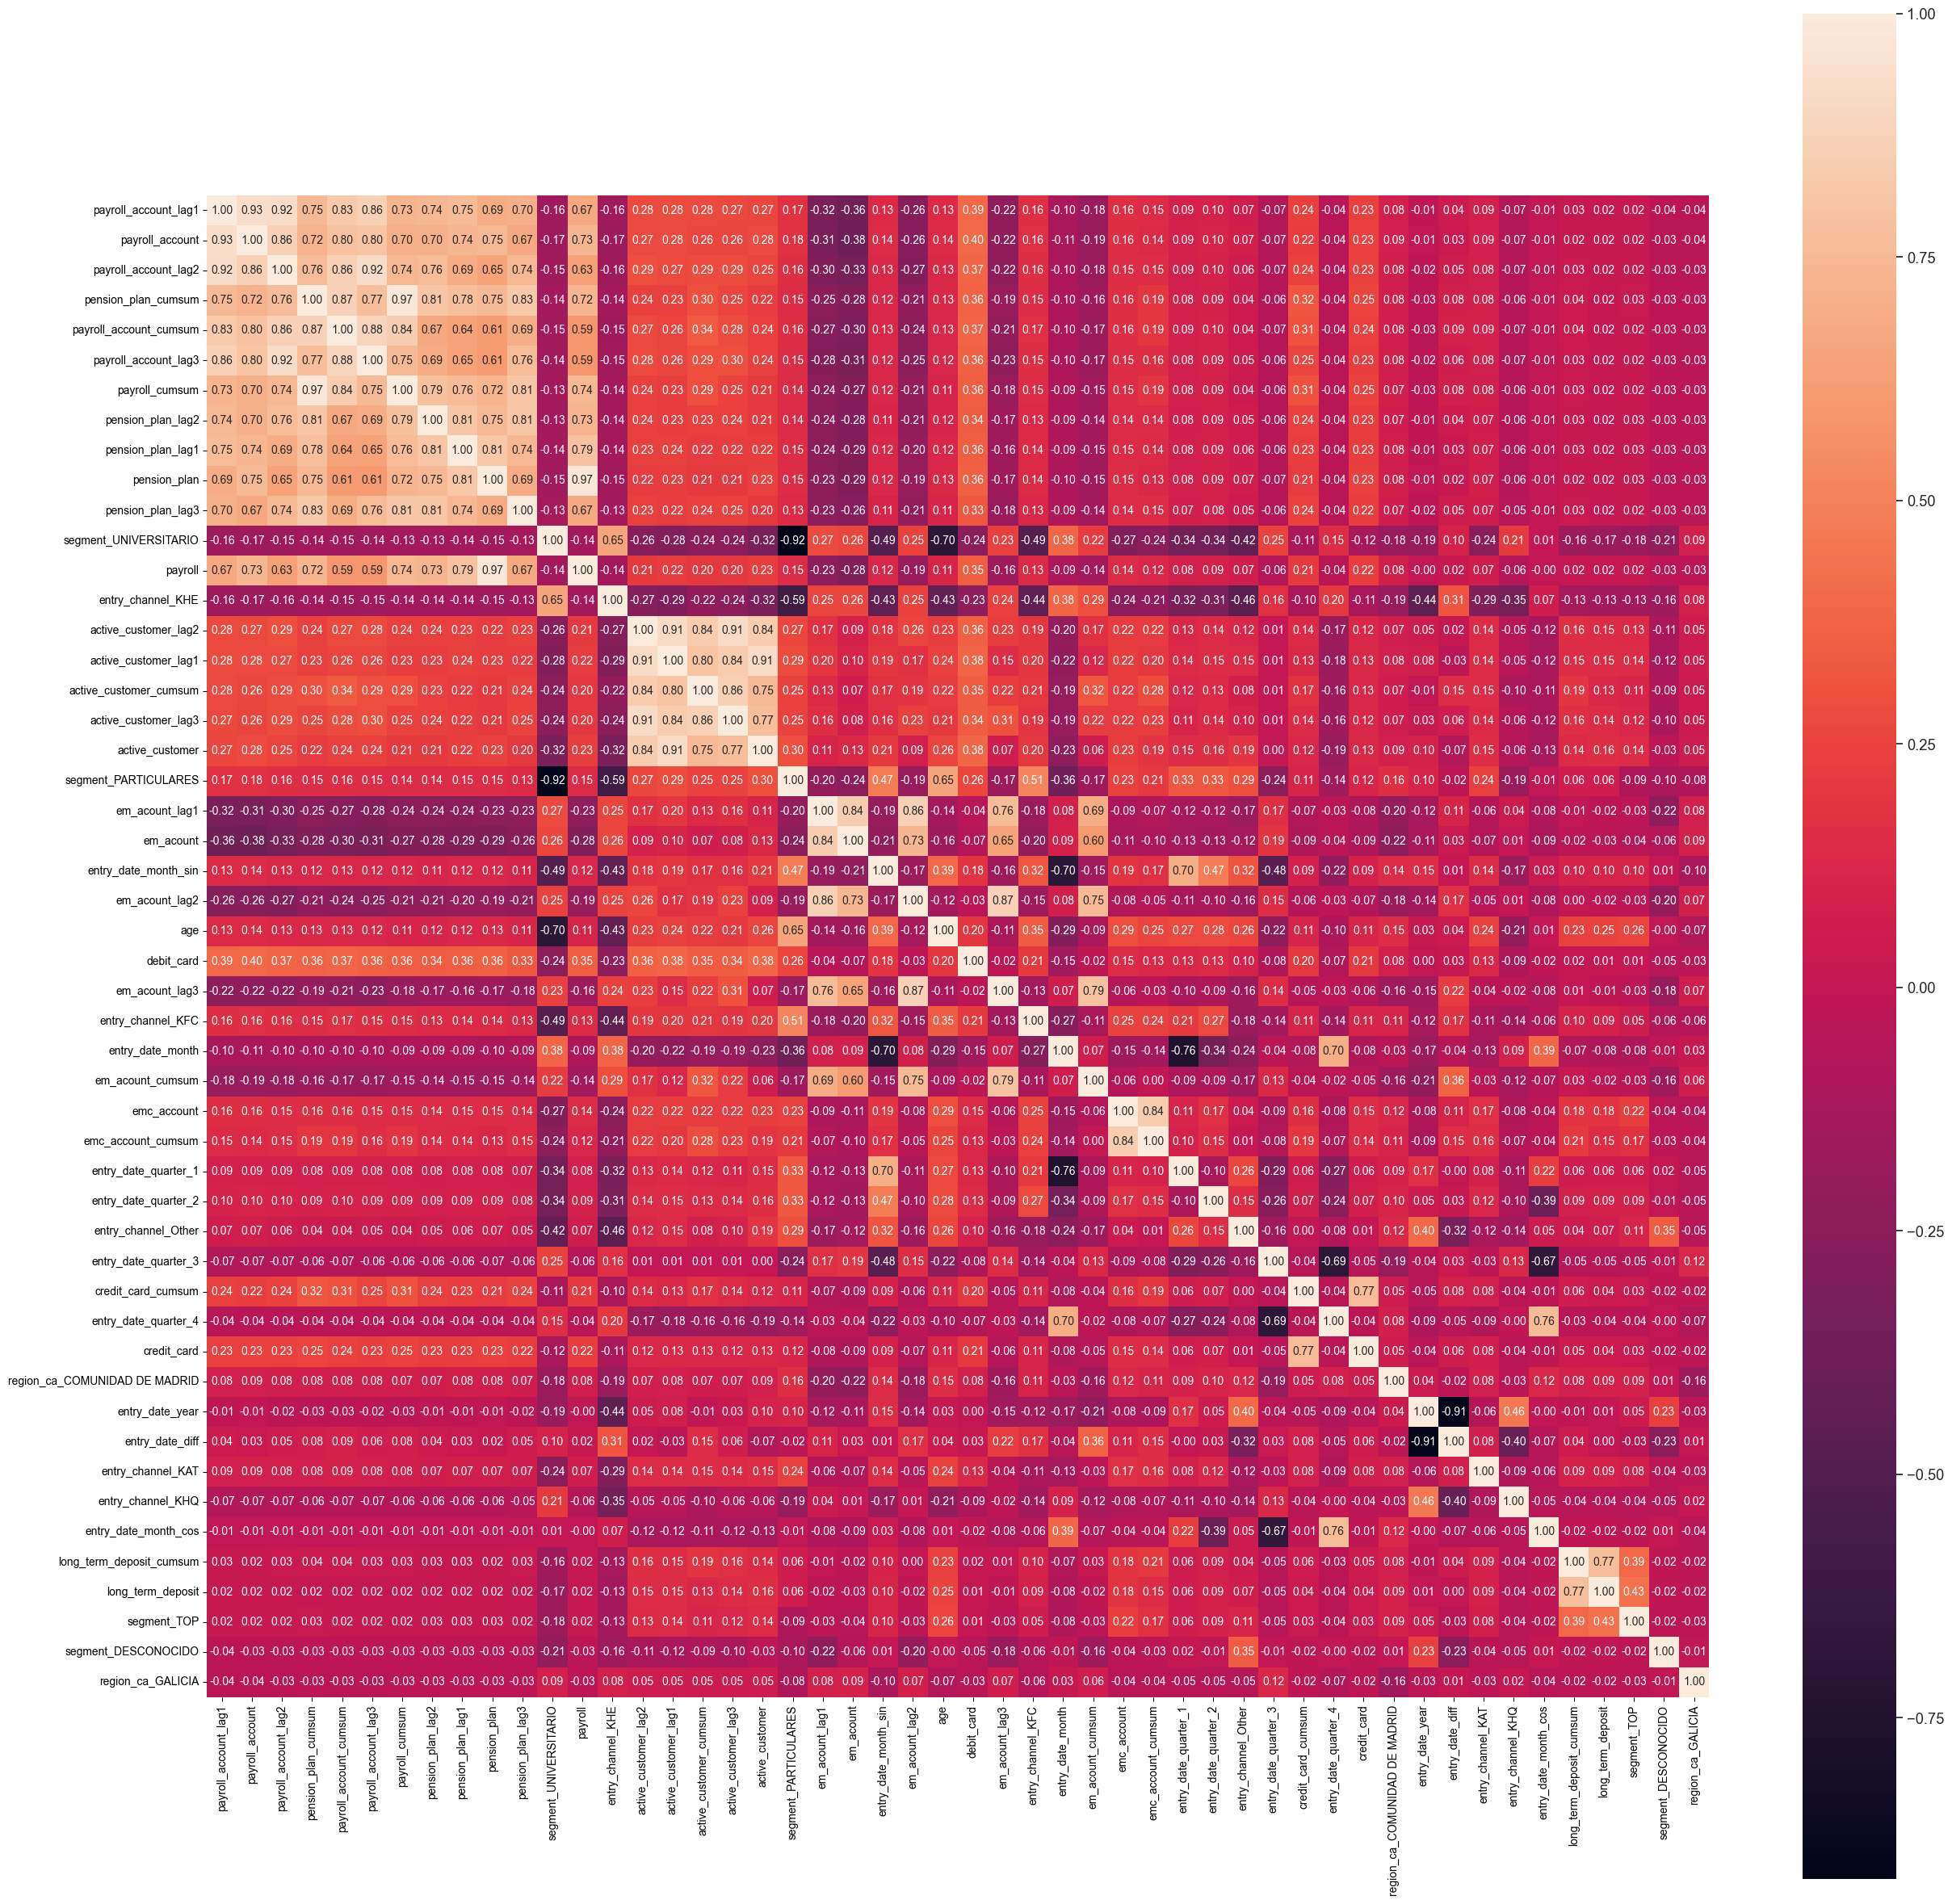

In [87]:
corr = X.corr().abs()
f, ax = plt.subplots(figsize=(30, 30))
mean_corr = corr.mean()
cols = mean_corr.nlargest(50).index # variables con mayor correlacion
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},yticklabels=cols, xticklabels=cols)
plt.show()

Se elimina entry_date_year por la alta correlación con entry_date_diff, ya que esta última nos proporciona más información.

In [88]:
del(df['entry_date_year'])

### Eliminacion de clientes que compraron

Se deja únicamente la fila del cliente el mes anterior a la compra donde hemos situado el Target a 1. De esta forma, el modelo no entrenará sobre clientes que ya han comprado y por consiguiente no tienen posibilidad de compra.

In [89]:
df_target = df[df[target] == 1] # Dataset de los clientes que compraron
cid_list = df_target['pk_cid'].to_list() # Lista de los clientes que compraron
df_not_target = df[~df['pk_cid'].isin(cid_list)] # Dataset de los clientes que no han comprado

# De esta forma nos queda un dataset con una unica fila por cliente que ha comprado
df = pd.concat([df_not_target, df_target], ignore_index=True)

#### Guardar pickle

In [90]:
pd.to_pickle(df,f"pickle/df_{target_product}_v4")

## Data modelling

In [91]:
df = pd.read_pickle(f"pickle/df_{target_product}_v4")

### Functions

Devuelve la matriz confusion

In [92]:
def getConfusionMatrix (model, X_test, y_test):

    y_test_pred = model.predict(X_test)

    matriz_confusion = confusion_matrix(y_test, y_test_pred)
    print("Matriz de Confusión:")

    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)
    disp.plot()
    plt.show()

Devuelve las metricas relacionadas con el F1 Score

In [93]:
def getF1 (model, X_test, y_test):
    y_test_pred = model.predict(X_test)

    precision = precision_score(y_test, y_test_pred)
    print(f'Precisión: {precision*100}')

    recall = recall_score(y_test, y_test_pred)
    print(f'Recall: {recall*100}')

    f1 = f1_score(y_test, y_test_pred)
    print(f'F1 Score: {f1*100}')


Devuelve el ROC y AUC del modelo

In [94]:
def getRocAuc (y_test, y_score):
    
    roc = roc_auc_score(y_test, y_score)
    print(f'ROC_AUC Score: {roc}')
    
    fpr, tpr, th = roc_curve(y_test, y_score)
    plt.plot(fpr,tpr)
    plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    J_scores = tpr - fpr
    best_th = th[J_scores.argmax()]
    print(f"Best threshold (Youden’s Index): {best_th}")

### Train/Test/Val split

In [95]:
# Train
df_train = df[(df['pk_partition'] > '2018-03-01') & (df['pk_partition'] < '2019-03-01')]
# Test
df_test = df[df['pk_partition'] == '2019-03-01'] # Antepenultimo mes como test
# Val
df_val = df[df['pk_partition'] == '2019-04-01'] # Penultimo mes como validacion

# Df para generar el grupo de propension
# No podemos usar este mes como validacion porque estamos entrenando un modelo para predecir que clientes compraran al mes siguiente y se ha realizado un shift -1 del target
df_p = df[df['pk_partition'] == '2019-05-01']

In [96]:
COLUMNS_TO_DROP = [
    'pk_partition',
    target_product
]


df_train = df_train.drop(COLUMNS_TO_DROP, axis=1)
df_train = df_train.drop('pk_cid', axis=1)

df_test = df_test.drop(COLUMNS_TO_DROP, axis=1)
df_test = df_test.set_index('pk_cid')

df_val = df_val.drop(COLUMNS_TO_DROP, axis=1)
df_val = df_val.set_index('pk_cid')

df_p = df_p.drop(COLUMNS_TO_DROP, axis=1)
df_p = df_p.set_index('pk_cid')

In [97]:
y_train = df_train[target]
X_train = df_train.drop(columns=[target]) 

y_test = df_test[target]
X_test = df_test.drop(columns=[target])

y_val = df_val[target]
X_val = df_val.drop(columns=[target])

### XGBoost

Se utiliza RandomUnderSampler para balancear el target debido a la alta desproporción que existe y evitar que se convierta en un modelo 'tonto'.

In [98]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = undersampler.fit_resample(X_train, y_train)

In [99]:
y_res.value_counts(normalize=True)

debit_card_sale
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

In [280]:
parameters = {
    'max_depth': [5, 6, 7],
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.05, 0.1, 0.3]
}

model_xgb = xgb.XGBClassifier(**parameters, device='cuda')

grid_search_model_xgb = GridSearchCV(
    model_xgb, 
    parameters,
    scoring='roc_auc', # estrategia de evaluacion
    verbose=1 # controla los mensajes por pantalla
    )

grid_search_model_xgb.fit(X_res, y_res)

print("Best params: \n", grid_search_model_xgb.best_params_)
print("\n\nScore: \n",grid_search_model_xgb.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: 
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}


Score: 
 0.8572345309023321


In [100]:
model_xgb = xgb.XGBClassifier(
    max_depth = 6, 
    learning_rate = 0.05, 
    n_estimators=100 
    
)
 
model_xgb.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Feature importance

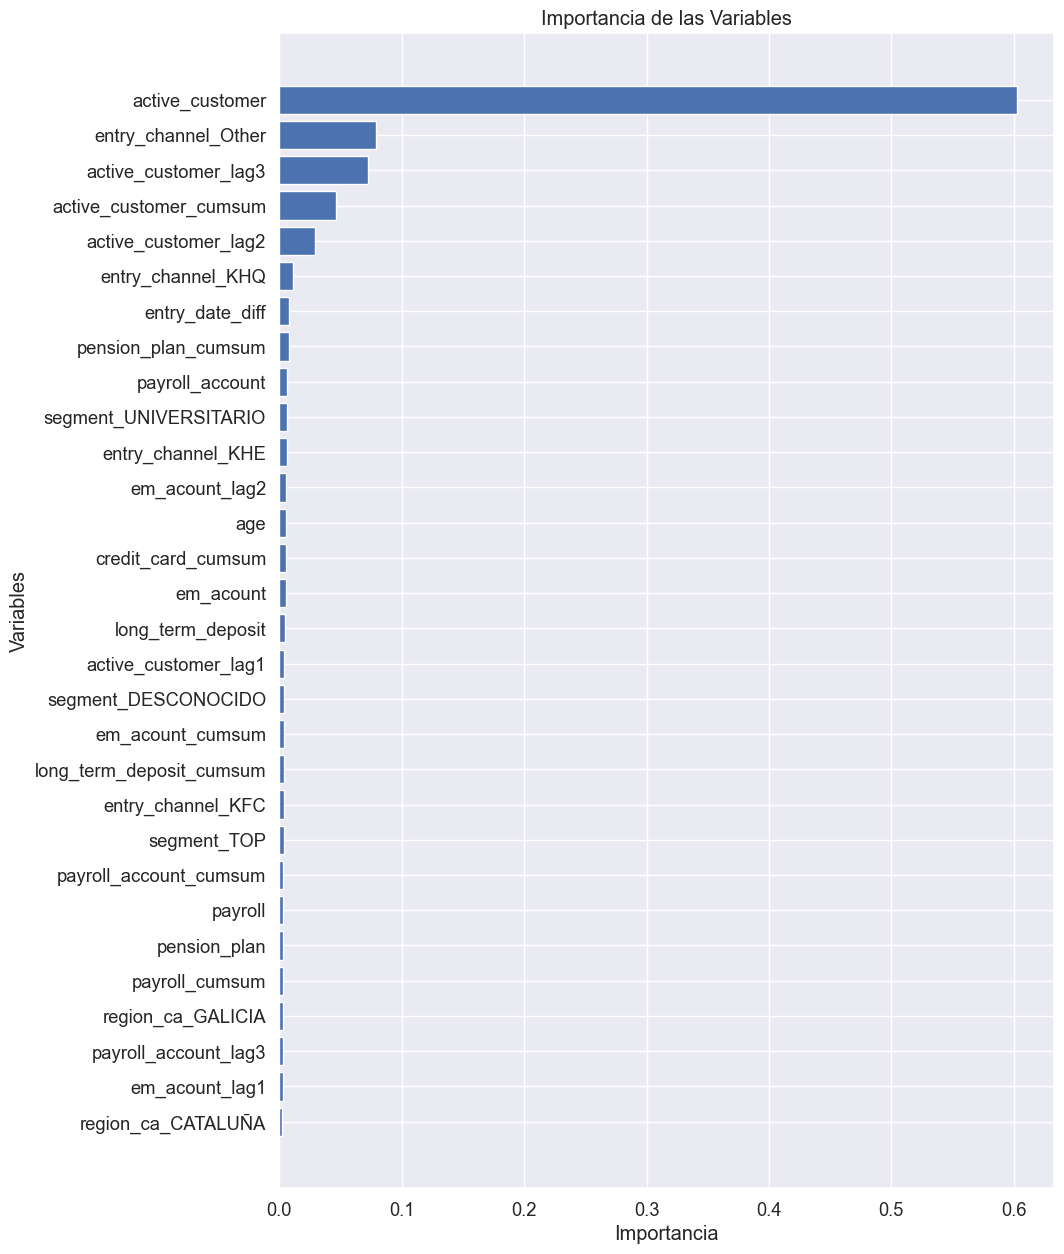

In [101]:
#Muestra las variables de mayor importancia para el modelo con feature_importances_ , quitando del grafico aquellas con minima relevancia
importances = model_xgb.feature_importances_
indices = np.argsort(importances)

# Seleccionamos las variables más importantes
num_features = 30
top_indices = indices[-num_features:]

plt.figure(figsize=(10, 15))
plt.barh(range(num_features), importances[top_indices], align='center')
plt.yticks(range(num_features), X_res.columns[top_indices])
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las Variables')
plt.show()

#### Metrics

In [102]:
test_accuracy = model_xgb.score(X_test,y_test)
print(f"Test Accuracy: {test_accuracy*100}")

Test Accuracy: 85.52716833301768


Matriz de Confusión:


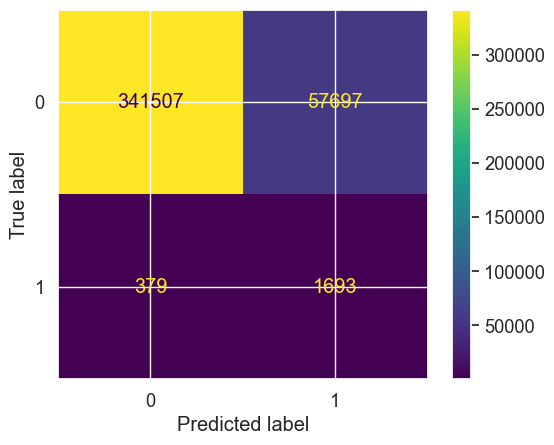

In [103]:
getConfusionMatrix(model_xgb, X_test, y_test)

In [104]:
getF1(model_xgb, X_test, y_test)

Precisión: 2.850648257282371
Recall: 81.70849420849422
F1 Score: 5.509095050600371


ROC_AUC Score: 0.9205899614750728
Best threshold (Youden’s Index): 0.4051201641559601


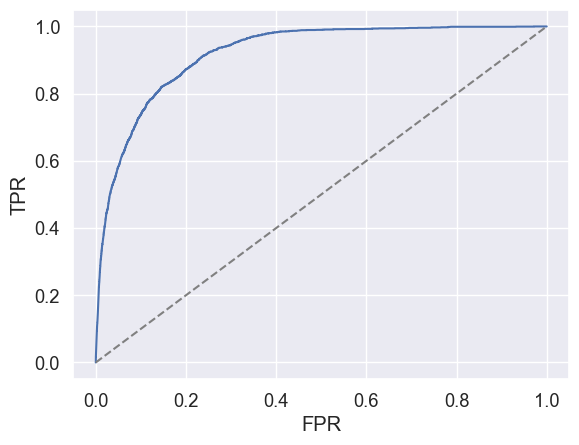

In [105]:
y_score = pd.DataFrame(model_xgb.predict_proba(X_test)[:,1], index = y_test.index, columns = [f'{target}_score'])
getRocAuc(y_test, y_score)

## Model evaluation

In [106]:
model = model_xgb

In [107]:
val_accuracy = model_xgb.score(X_val,y_val)
print(f"Validation Accuracy: {val_accuracy*100}")

Validation Accuracy: 85.31114380741602


### Confusion matrix

Matriz de Confusión:


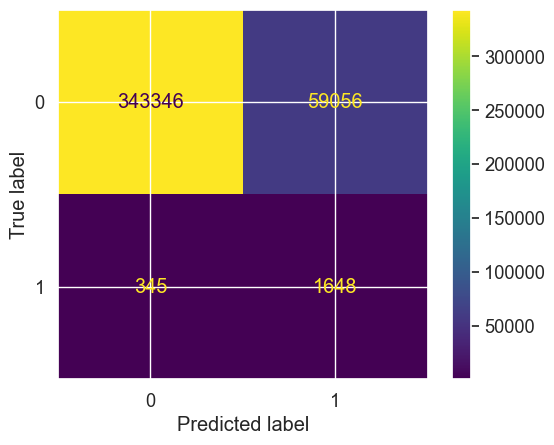

In [108]:
getConfusionMatrix(model, X_val, y_val)

### F1 Score

In [109]:
getF1(model, X_val, y_val)

Precisión: 2.7148128624143384
Recall: 82.68941294530859
F1 Score: 5.257029841938211


### ROC/AUC

ROC_AUC Score: 0.9224398069123264
Best threshold (Youden’s Index): 0.46753090620040894


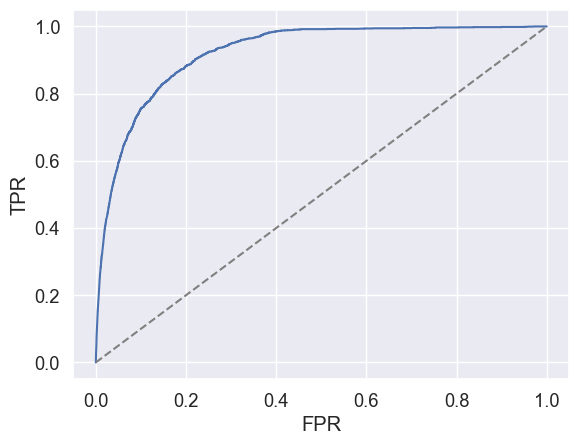

In [110]:
y_score = pd.DataFrame(model.predict_proba(X_val)[:,1], index = y_val.index, columns = [f'{target}_score'])

getRocAuc(y_val, y_score)

## Lista de propensión

Comprobación del threshold más adecuado para obtener una lista de clientes para la campaña.

Matriz de Confusión:


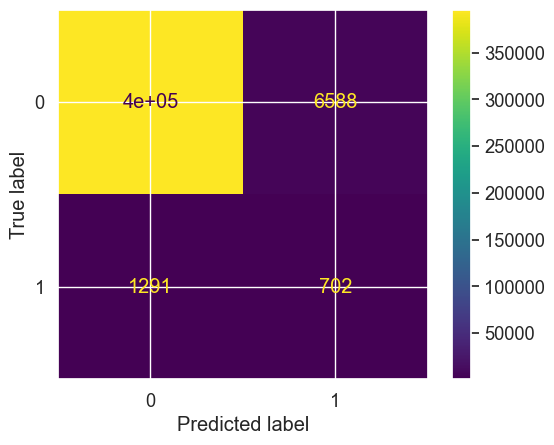

In [111]:
y_prob = model.predict_proba(X_val)[:, 1]
y_pred = (y_prob >= 0.9).astype(int)


matriz_confusion = confusion_matrix(y_val, y_pred)
print("Matriz de Confusión:")

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)
disp.plot()
plt.show()

In [112]:
X_p = df_p.drop(columns=[target])

y_p = model.predict_proba(X_p)[:, 1]

In [113]:
# Crear un DataFrame con las probabilidades
results_df = pd.DataFrame({'Probability': y_p}, index=X_p.index)

# Ordenar por la probabilidad de la clase positiva
sorted_results = results_df.sort_values(by='Probability', ascending=False)

top_clients = sorted_results[sorted_results['Probability'] > 0.9]

In [114]:
top_clients

,Probability
pk_cid,
1545432,0.975624
1545184,0.975504
1546758,0.975376
1223845,0.975253
1544756,0.975236
...,...
1546260,0.900140
1537825,0.900108
1357036,0.900058


Se obtiene un listado de 6500 clientes con mayor propensión de compra para el 06-2019.

### Guardar pickle

In [115]:
pd.to_pickle(top_clients,f"pickle/df_top_{target_product}")